In [1]:
import dLux as dl
import dLux.utils as dlu
import dLuxToliman as dlT
import jax.random as jr
import jax.numpy as np
import matplotlib.pyplot as plt
import numpyro as npy
import numpyro.distributions as dist
from jax import device_count
from scipy.special import jv

In [2]:
wf_npix = 128 # lowest necessary amount
diameter = 0.125
coords = dlu.pixel_coords(wf_npix, diameter)
aperture = dlu.circle(coords, 0.5*diameter)

psf_npix = 64
psf_pixel_scale = 0.375 #arcsec
oversample = 2 #fairly shite.. hopefully doesn't come back to bite us

layers = [
    (
        'aperture',
        dl.layers.TransmissiveLayer(aperture, normalise=True)
    )
]

optics = dl.AngularOpticalSystem(
    wf_npix, diameter, layers, psf_npix, psf_pixel_scale, oversample
)

wavelength = 585e-9

fluxes = np.logspace(2, 6, 5)
print(fluxes)
# for some reason, for fluxes above 1 million (i.e. 10^7 and greater), seems to break

num_trials = 10 # 10 just takes so long.. only if oversample is high.

# numpyro stuff
parameters = ['wavelengths']

def psf_model(data, model, flux, toliman=False, center_wl=None):
    
    if toliman == False:
        values = [
            npy.sample("wavelength",    dist.Uniform(wavelength*(1-0.02*np.sqrt(1000)/np.sqrt(flux)), wavelength*(1+0.02*np.sqrt(1000)/np.sqrt(flux))))
        ]
    else:
        values = [
            npy.sample("wavelength",    dist.Uniform(wavelength*(1-0.00008*np.sqrt(1000)/np.sqrt(flux)), wavelength*(1+0.00008*np.sqrt(1000)/np.sqrt(flux))))
        ] 
    # made the distribution scale with 1 / sqrt flux so that it's well behaved.

    with npy.plate("data", len(data.flatten())):
        if toliman == False:
            poisson_model = dist.Poisson(
                model.set(parameters, values).model().flatten()
            )
        else:
            poisson_model = dist.Poisson(
                model.set(parameters, values).model_sidelobes(center_wavelength = center_wl).flatten()
            )  
        return npy.sample("psf", poisson_model, obs=data.flatten())
    
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),
    num_warmup=200,
    num_samples=200,
    num_chains=device_count(),
    progress_bar=True,
)

#rmax and cramer rao bound functions
def rmax(psf_pixel_scale, psf_npix):
    rmax = np.sqrt(2)*dlu.arcsec2rad(psf_npix * psf_pixel_scale/2) # divide by 2 for radius, sqrt2 because more pixels along the diagonal.
    return rmax

our_rmax = rmax(psf_pixel_scale, psf_npix)

def crb(wavelength, flux, diameter, rmax):
    crb = (wavelength**(3/2)/(2*(flux*(2*diameter*rmax - wavelength))**0.5)) * (10**9) # gonna convert to nm here too!
    return crb

# just calculated toliman cramer bound, gonna include it here for comparison
def crb_toliman(wavelength, flux, diameter, period):
    crb_toliman = np.sqrt( (3 * np.pi * period**2 * wavelength**2) / (2 * flux * (3 * np.pi**3 * diameter**2 + period**2 * (9 * np.pi - 16) ) ) ) * (10**9) #convert to nm
    return crb_toliman

[1.e+02 1.e+03 1.e+04 1.e+05 1.e+06]


sample: 100%|██████████| 400/400 [00:03<00:00, 131.93it/s, 1 steps of size 1.07e+00. acc. prob=0.93] 


CPU times: user 5.45 s, sys: 332 ms, total: 5.78 s
Wall time: 3.3 s


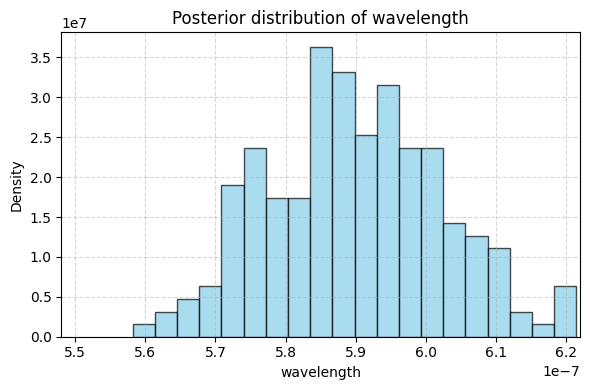

sample: 100%|██████████| 400/400 [00:02<00:00, 148.53it/s, 1 steps of size 8.35e-01. acc. prob=0.92] 


CPU times: user 5.03 s, sys: 220 ms, total: 5.25 s
Wall time: 2.78 s


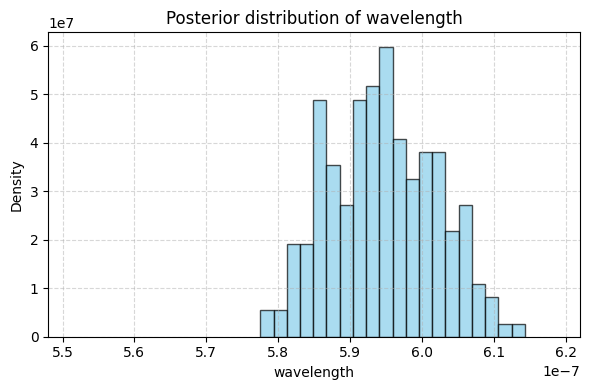

sample: 100%|██████████| 400/400 [00:03<00:00, 125.37it/s, 1 steps of size 7.19e-01. acc. prob=0.95]

CPU times: user 6.04 s, sys: 260 ms, total: 6.3 s
Wall time: 3.27 s


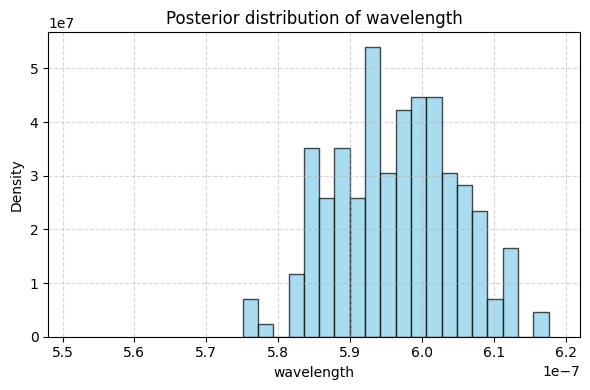

sample: 100%|██████████| 400/400 [00:02<00:00, 136.46it/s, 3 steps of size 1.09e+00. acc. prob=0.94] 


CPU times: user 5.6 s, sys: 237 ms, total: 5.84 s
Wall time: 3.02 s


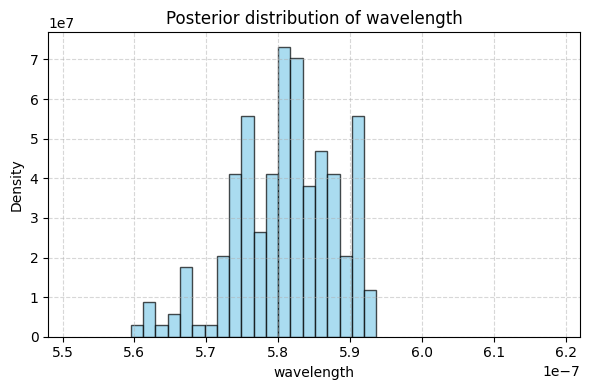

sample: 100%|██████████| 400/400 [00:02<00:00, 158.73it/s, 1 steps of size 6.72e-01. acc. prob=0.93] 


CPU times: user 4.74 s, sys: 190 ms, total: 4.93 s
Wall time: 2.61 s


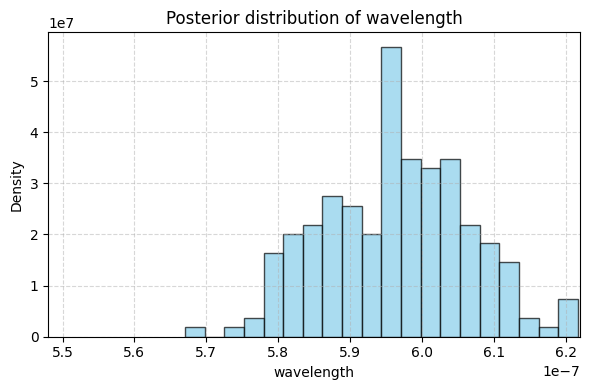

sample: 100%|██████████| 400/400 [00:02<00:00, 142.63it/s, 3 steps of size 9.12e-01. acc. prob=0.92]


CPU times: user 5.38 s, sys: 219 ms, total: 5.59 s
Wall time: 2.94 s


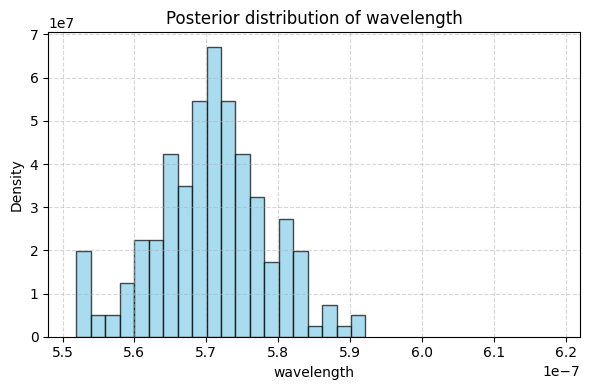

sample: 100%|██████████| 400/400 [00:02<00:00, 154.98it/s, 1 steps of size 8.99e-01. acc. prob=0.94]


CPU times: user 5.04 s, sys: 213 ms, total: 5.25 s
Wall time: 2.66 s


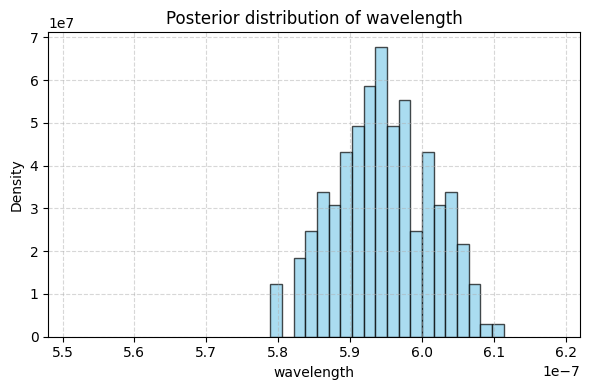

sample: 100%|██████████| 400/400 [00:02<00:00, 144.24it/s, 7 steps of size 8.28e-01. acc. prob=0.94]

CPU times: user 5.26 s, sys: 218 ms, total: 5.48 s
Wall time: 2.86 s


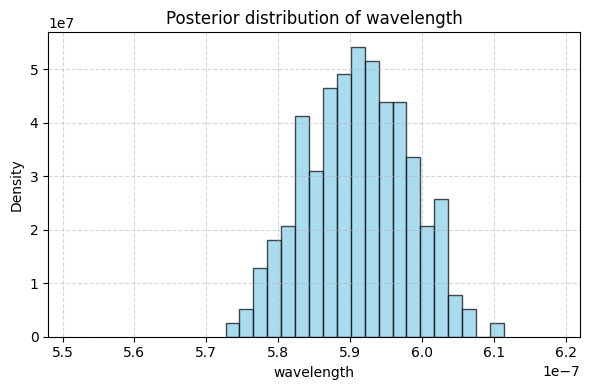

sample: 100%|██████████| 400/400 [00:02<00:00, 147.74it/s, 1 steps of size 6.64e-01. acc. prob=0.94]


CPU times: user 5.11 s, sys: 209 ms, total: 5.32 s
Wall time: 2.85 s


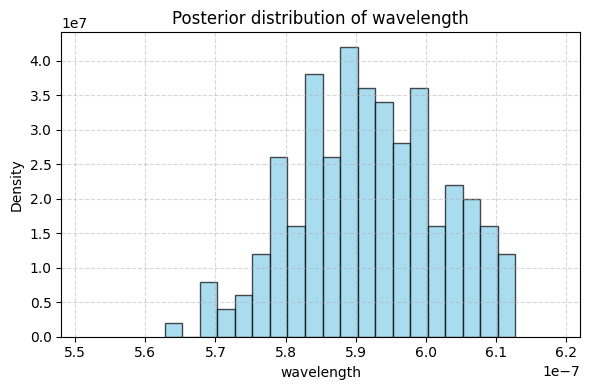

sample: 100%|██████████| 400/400 [00:02<00:00, 141.79it/s, 3 steps of size 1.13e+00. acc. prob=0.94]

CPU times: user 5.34 s, sys: 222 ms, total: 5.57 s
Wall time: 2.91 s


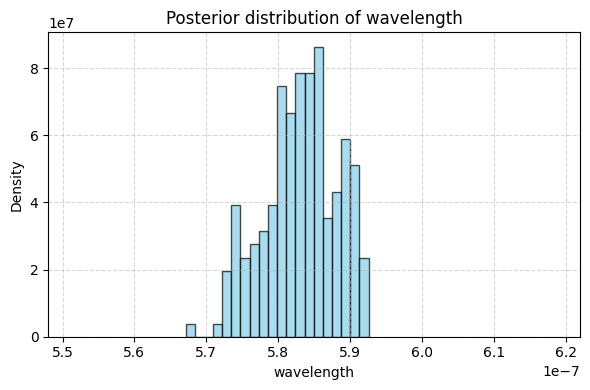

sample: 100%|██████████| 400/400 [00:02<00:00, 160.35it/s, 1 steps of size 1.00e+00. acc. prob=0.92]

CPU times: user 4.61 s, sys: 193 ms, total: 4.8 s
Wall time: 2.57 s


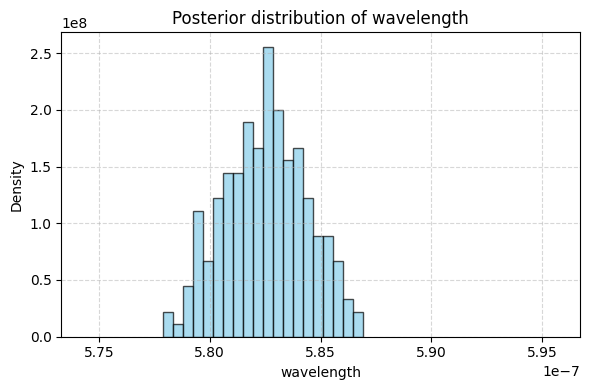

sample: 100%|██████████| 400/400 [00:02<00:00, 154.04it/s, 1 steps of size 1.36e+00. acc. prob=0.92]

CPU times: user 4.69 s, sys: 197 ms, total: 4.89 s
Wall time: 2.74 s


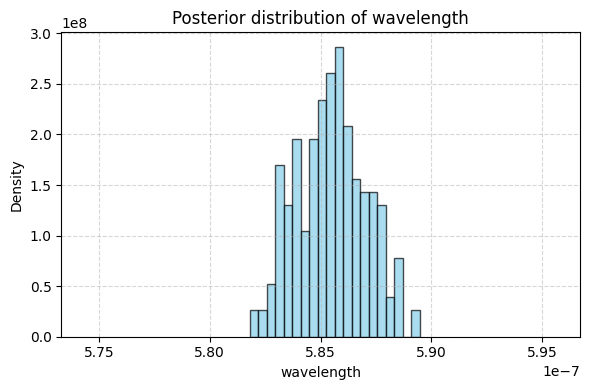

sample: 100%|██████████| 400/400 [00:02<00:00, 143.10it/s, 3 steps of size 7.39e-01. acc. prob=0.94]

CPU times: user 5.25 s, sys: 227 ms, total: 5.48 s
Wall time: 2.88 s


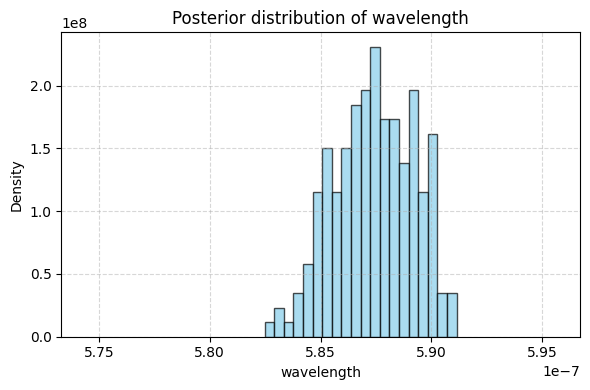

sample: 100%|██████████| 400/400 [00:02<00:00, 147.78it/s, 1 steps of size 1.03e+00. acc. prob=0.93] 

CPU times: user 4.9 s, sys: 217 ms, total: 5.12 s
Wall time: 2.79 s


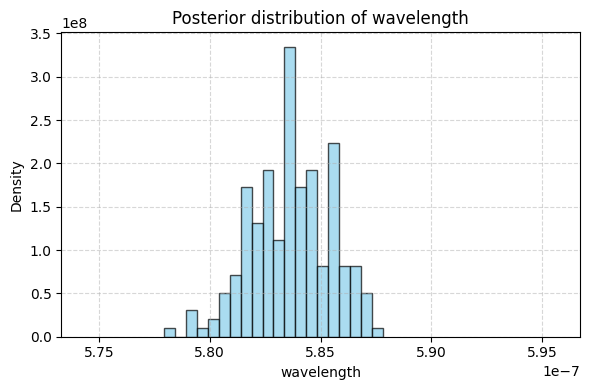

sample: 100%|██████████| 400/400 [00:02<00:00, 149.62it/s, 3 steps of size 1.10e+00. acc. prob=0.95] 


CPU times: user 5.24 s, sys: 229 ms, total: 5.47 s
Wall time: 2.76 s


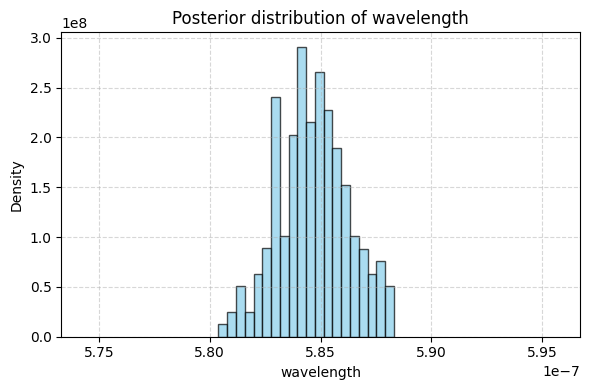

sample: 100%|██████████| 400/400 [00:02<00:00, 145.62it/s, 1 steps of size 1.01e+00. acc. prob=0.93]


CPU times: user 5.13 s, sys: 218 ms, total: 5.35 s
Wall time: 2.83 s


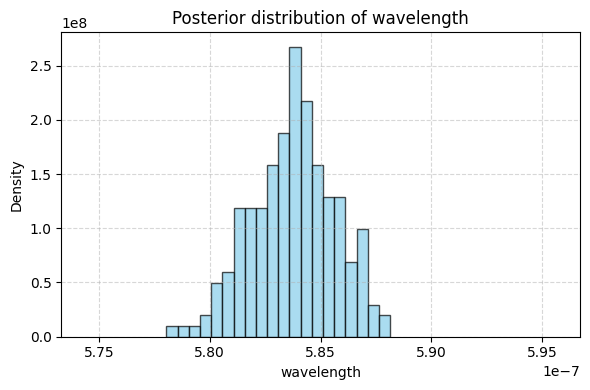

sample: 100%|██████████| 400/400 [00:02<00:00, 148.55it/s, 1 steps of size 1.44e+00. acc. prob=0.93]


CPU times: user 4.91 s, sys: 216 ms, total: 5.12 s
Wall time: 2.78 s


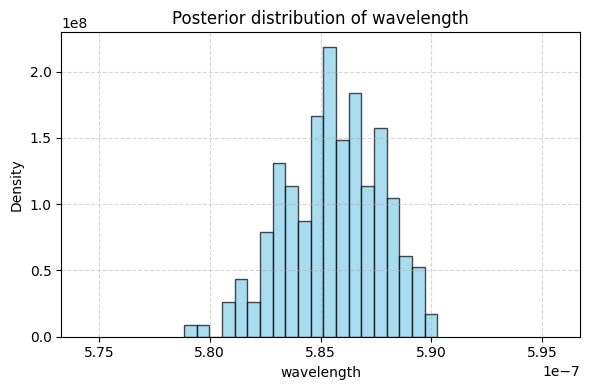

sample: 100%|██████████| 400/400 [00:02<00:00, 154.97it/s, 1 steps of size 1.07e+00. acc. prob=0.92]

CPU times: user 4.79 s, sys: 203 ms, total: 4.99 s
Wall time: 2.67 s


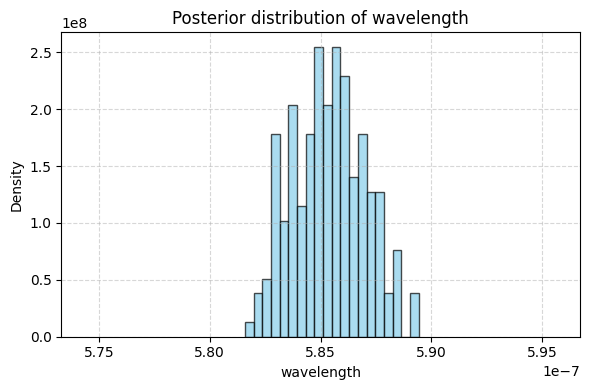

sample: 100%|██████████| 400/400 [00:02<00:00, 141.15it/s, 1 steps of size 1.36e+00. acc. prob=0.93]

CPU times: user 5.34 s, sys: 230 ms, total: 5.57 s
Wall time: 2.92 s


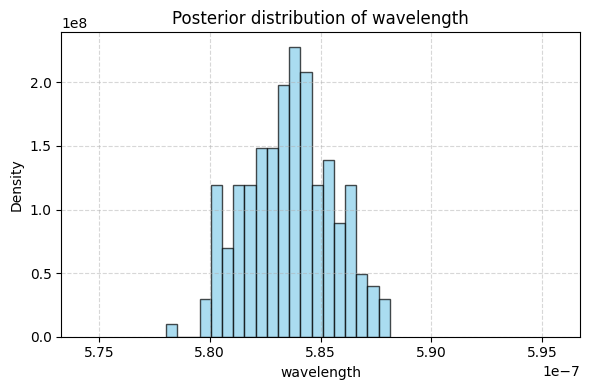

sample: 100%|██████████| 400/400 [00:02<00:00, 143.21it/s, 1 steps of size 8.62e-01. acc. prob=0.93] 


CPU times: user 5.14 s, sys: 224 ms, total: 5.36 s
Wall time: 2.88 s


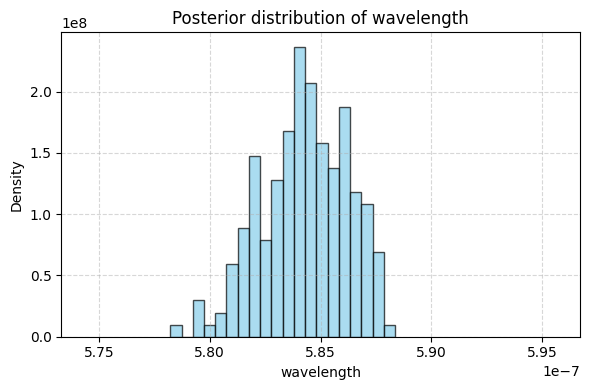

sample: 100%|██████████| 400/400 [00:02<00:00, 158.90it/s, 3 steps of size 1.13e+00. acc. prob=0.88]


CPU times: user 4.65 s, sys: 200 ms, total: 4.85 s
Wall time: 2.6 s


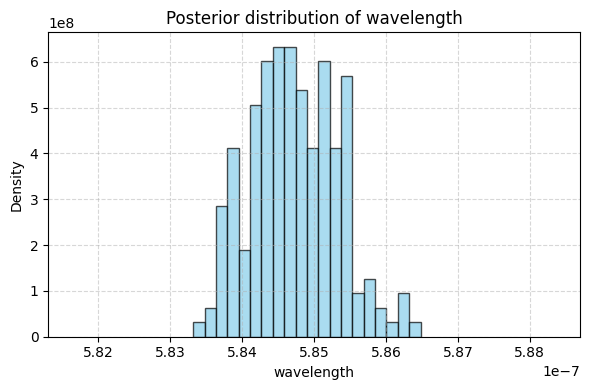

sample: 100%|██████████| 400/400 [00:02<00:00, 135.82it/s, 1 steps of size 9.35e-01. acc. prob=0.92]

CPU times: user 5.61 s, sys: 231 ms, total: 5.84 s
Wall time: 3.04 s


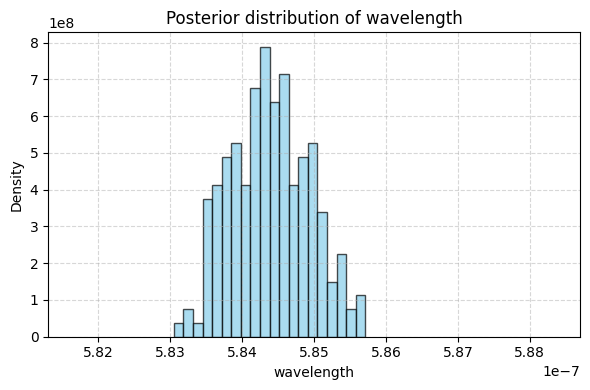

sample: 100%|██████████| 400/400 [00:02<00:00, 163.20it/s, 1 steps of size 1.06e+00. acc. prob=0.94] 


CPU times: user 4.74 s, sys: 201 ms, total: 4.95 s
Wall time: 2.6 s


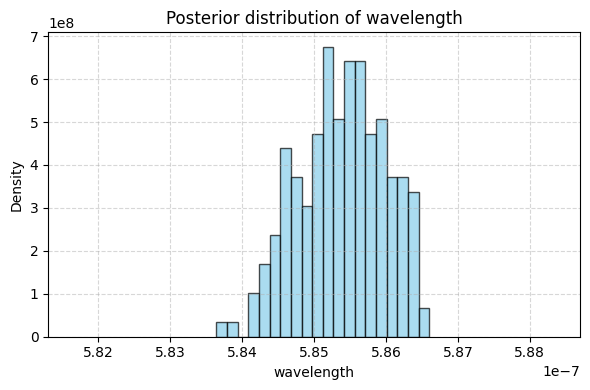

sample: 100%|██████████| 400/400 [00:02<00:00, 149.43it/s, 1 steps of size 9.06e-01. acc. prob=0.94] 


CPU times: user 5.03 s, sys: 213 ms, total: 5.25 s
Wall time: 2.78 s


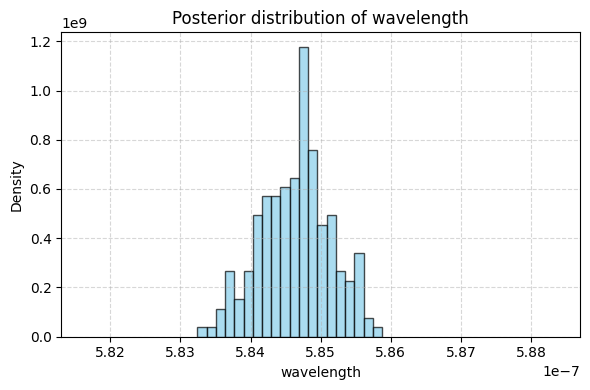

sample: 100%|██████████| 400/400 [00:03<00:00, 119.24it/s, 1 steps of size 6.31e-01. acc. prob=0.94]


CPU times: user 6.39 s, sys: 265 ms, total: 6.66 s
Wall time: 3.44 s


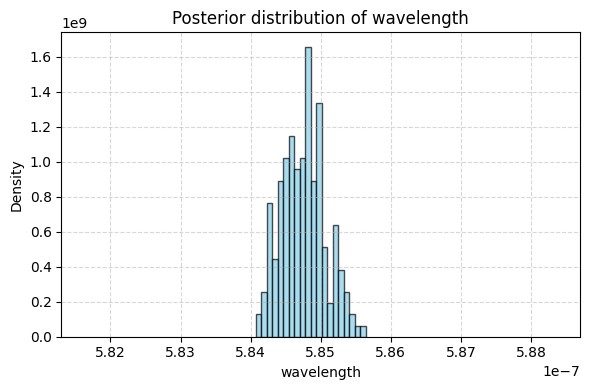

sample: 100%|██████████| 400/400 [00:02<00:00, 156.80it/s, 1 steps of size 9.73e-01. acc. prob=0.92]

CPU times: user 4.73 s, sys: 200 ms, total: 4.93 s
Wall time: 2.64 s


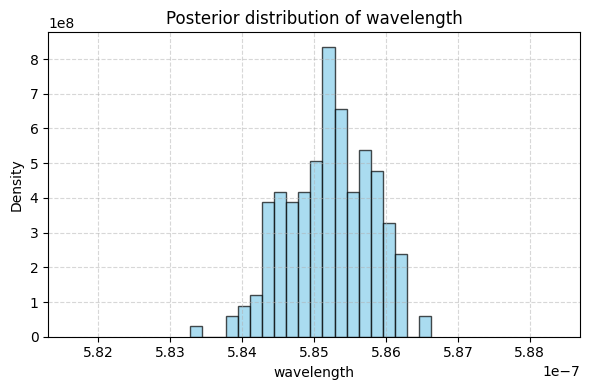

sample: 100%|██████████| 400/400 [00:02<00:00, 148.97it/s, 1 steps of size 1.22e+00. acc. prob=0.94] 


CPU times: user 5.05 s, sys: 212 ms, total: 5.26 s
Wall time: 2.77 s


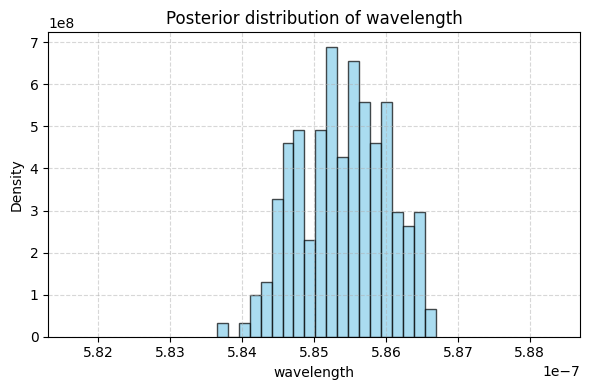

sample: 100%|██████████| 400/400 [00:02<00:00, 144.55it/s, 1 steps of size 8.91e-01. acc. prob=0.95]


CPU times: user 5.21 s, sys: 218 ms, total: 5.43 s
Wall time: 2.92 s


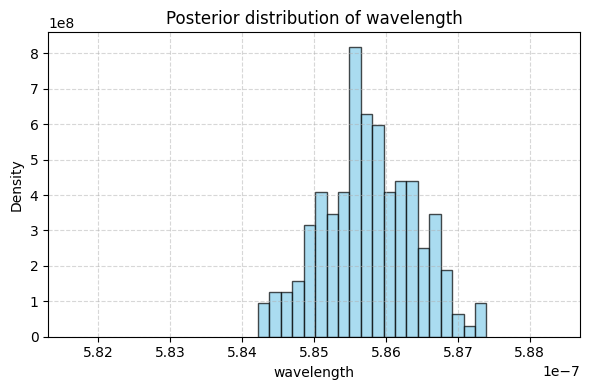

sample: 100%|██████████| 400/400 [00:02<00:00, 152.61it/s, 1 steps of size 1.12e+00. acc. prob=0.93] 


CPU times: user 4.87 s, sys: 208 ms, total: 5.08 s
Wall time: 2.71 s


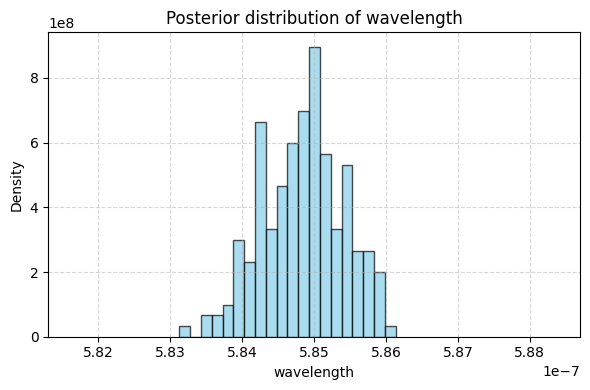

sample: 100%|██████████| 400/400 [00:02<00:00, 140.77it/s, 1 steps of size 1.10e+00. acc. prob=0.92] 


CPU times: user 5.26 s, sys: 227 ms, total: 5.49 s
Wall time: 2.94 s


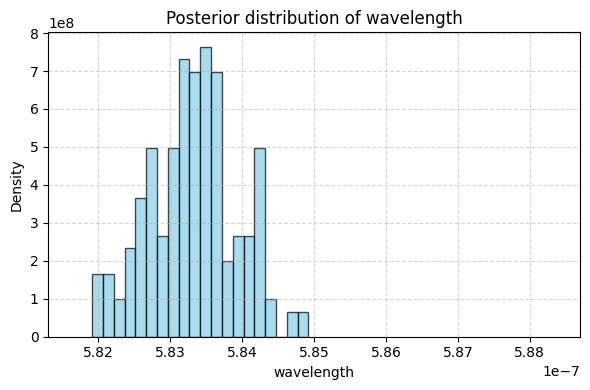

sample: 100%|██████████| 400/400 [00:02<00:00, 173.00it/s, 1 steps of size 9.80e-01. acc. prob=0.92] 


CPU times: user 4.39 s, sys: 195 ms, total: 4.59 s
Wall time: 2.4 s


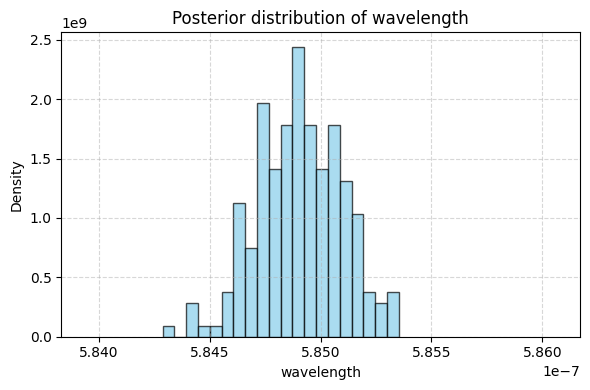

sample: 100%|██████████| 400/400 [00:02<00:00, 155.94it/s, 1 steps of size 1.08e+00. acc. prob=0.93]

CPU times: user 4.77 s, sys: 207 ms, total: 4.97 s
Wall time: 2.66 s


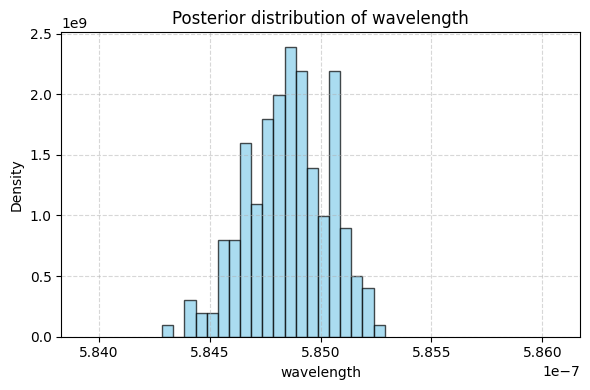

sample: 100%|██████████| 400/400 [00:02<00:00, 149.82it/s, 1 steps of size 1.34e+00. acc. prob=0.93] 


CPU times: user 4.9 s, sys: 207 ms, total: 5.11 s
Wall time: 2.76 s


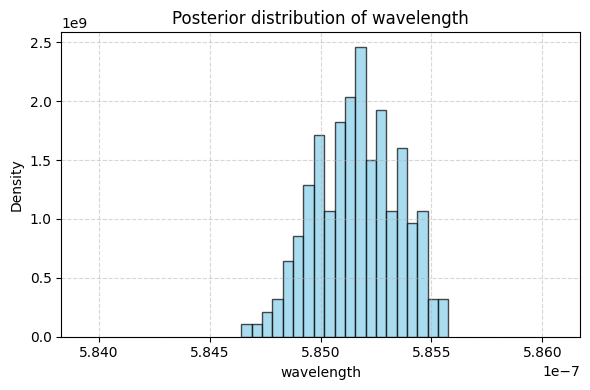

sample: 100%|██████████| 400/400 [00:02<00:00, 150.07it/s, 1 steps of size 1.32e+00. acc. prob=0.91] 


CPU times: user 4.98 s, sys: 212 ms, total: 5.19 s
Wall time: 2.76 s


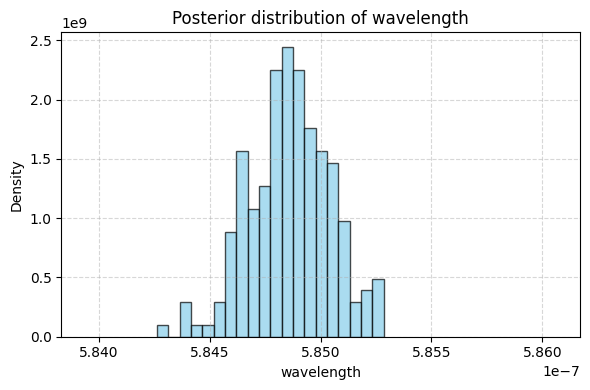

sample: 100%|██████████| 400/400 [00:02<00:00, 145.03it/s, 1 steps of size 7.89e-01. acc. prob=0.94]

CPU times: user 5.03 s, sys: 226 ms, total: 5.25 s
Wall time: 2.85 s


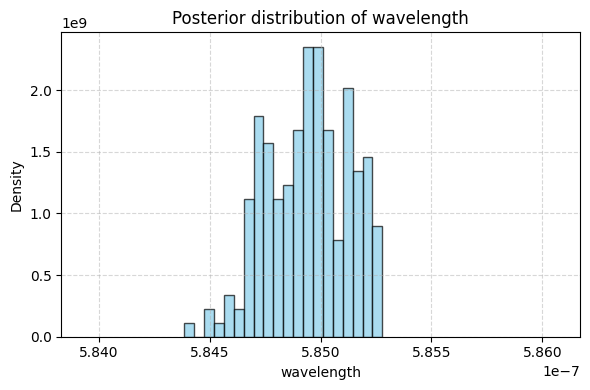

sample: 100%|██████████| 400/400 [00:02<00:00, 153.09it/s, 1 steps of size 1.03e+00. acc. prob=0.93] 


CPU times: user 4.84 s, sys: 209 ms, total: 5.05 s
Wall time: 2.7 s


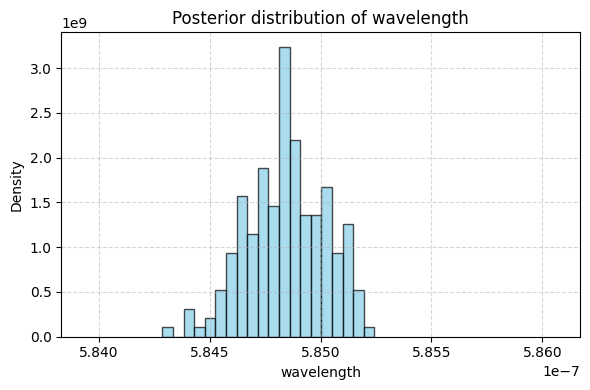

sample: 100%|██████████| 400/400 [00:02<00:00, 140.58it/s, 3 steps of size 7.94e-01. acc. prob=0.94]

CPU times: user 5.36 s, sys: 229 ms, total: 5.59 s
Wall time: 2.94 s


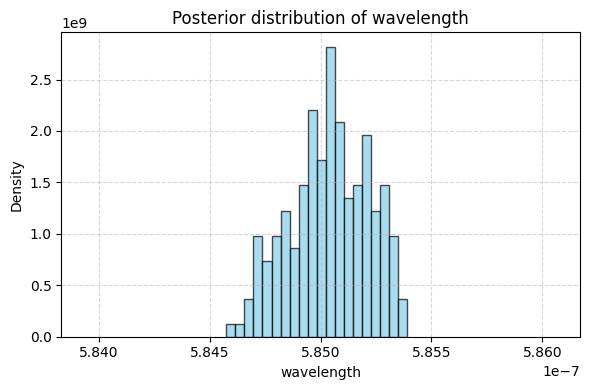

sample: 100%|██████████| 400/400 [00:02<00:00, 135.89it/s, 1 steps of size 9.03e-01. acc. prob=0.94] 


CPU times: user 5.38 s, sys: 233 ms, total: 5.61 s
Wall time: 3.09 s


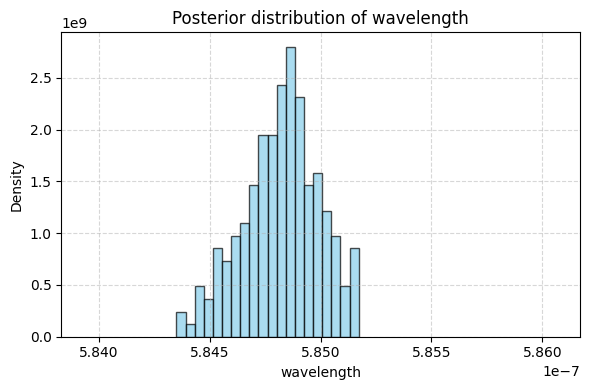

sample: 100%|██████████| 400/400 [00:02<00:00, 162.52it/s, 1 steps of size 9.19e-01. acc. prob=0.93]

CPU times: user 4.74 s, sys: 202 ms, total: 4.94 s
Wall time: 2.55 s


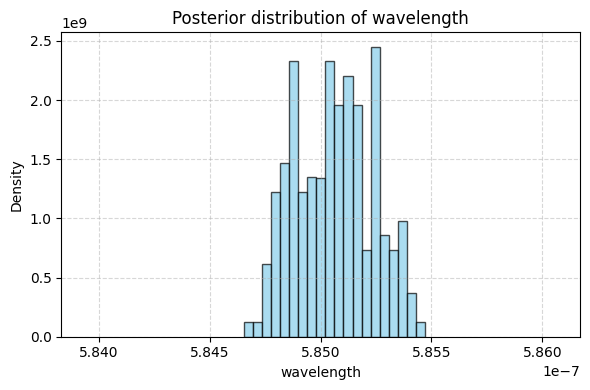

sample: 100%|██████████| 400/400 [00:02<00:00, 152.95it/s, 1 steps of size 7.87e-01. acc. prob=0.93] 

CPU times: user 4.75 s, sys: 195 ms, total: 4.94 s
Wall time: 2.71 s


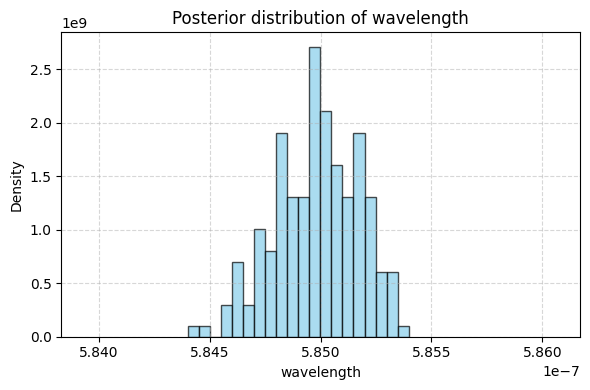

sample: 100%|██████████| 400/400 [00:02<00:00, 147.26it/s, 1 steps of size 1.02e+00. acc. prob=0.92] 


CPU times: user 5.1 s, sys: 213 ms, total: 5.31 s
Wall time: 2.81 s


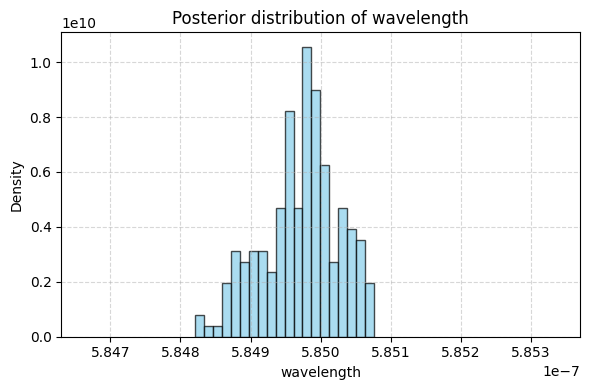

sample: 100%|██████████| 400/400 [00:02<00:00, 143.62it/s, 3 steps of size 7.61e-01. acc. prob=0.93]

CPU times: user 5.26 s, sys: 223 ms, total: 5.49 s
Wall time: 2.88 s


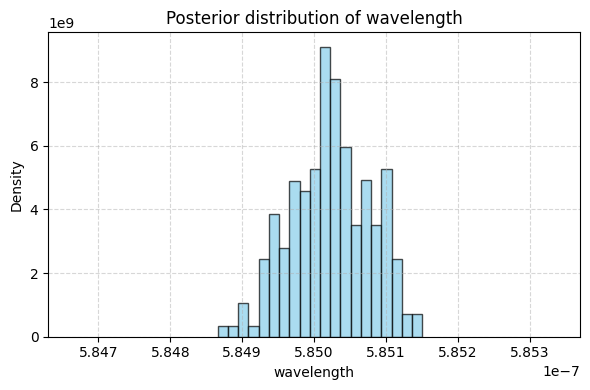

sample: 100%|██████████| 400/400 [00:02<00:00, 149.36it/s, 1 steps of size 1.22e+00. acc. prob=0.92]

CPU times: user 5.02 s, sys: 209 ms, total: 5.23 s
Wall time: 2.84 s


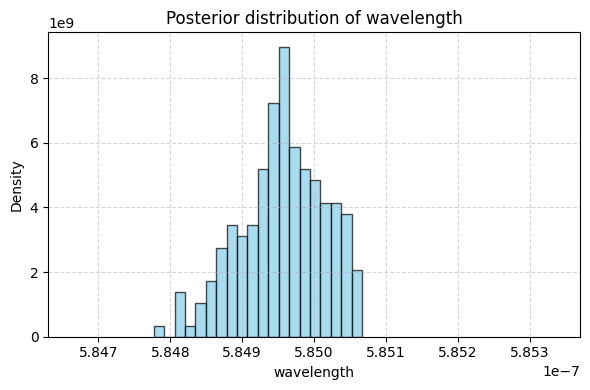

sample: 100%|██████████| 400/400 [00:02<00:00, 142.46it/s, 1 steps of size 1.28e+00. acc. prob=0.93]


CPU times: user 5.29 s, sys: 226 ms, total: 5.51 s
Wall time: 2.9 s


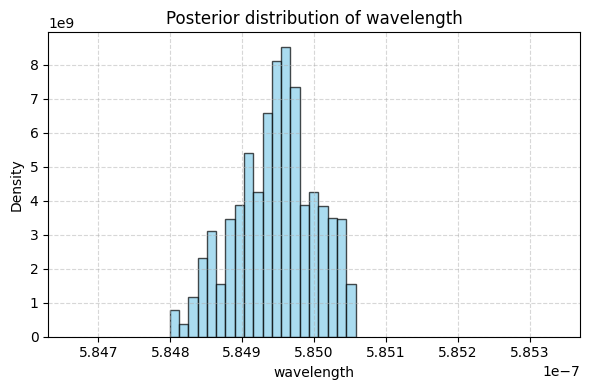

sample: 100%|██████████| 400/400 [00:02<00:00, 144.17it/s, 1 steps of size 1.17e+00. acc. prob=0.92]

CPU times: user 5.1 s, sys: 225 ms, total: 5.33 s
Wall time: 2.86 s


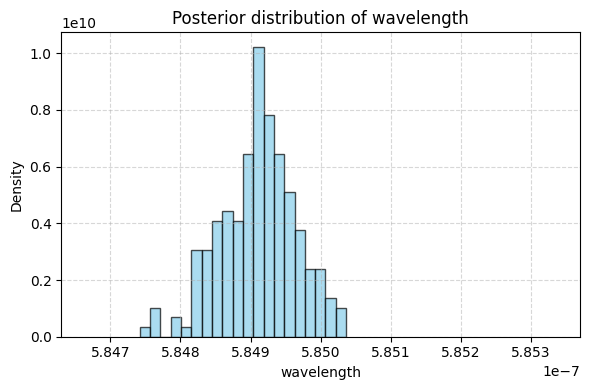

sample: 100%|██████████| 400/400 [00:02<00:00, 146.33it/s, 1 steps of size 8.31e-01. acc. prob=0.92] 


CPU times: user 5.13 s, sys: 221 ms, total: 5.35 s
Wall time: 2.83 s


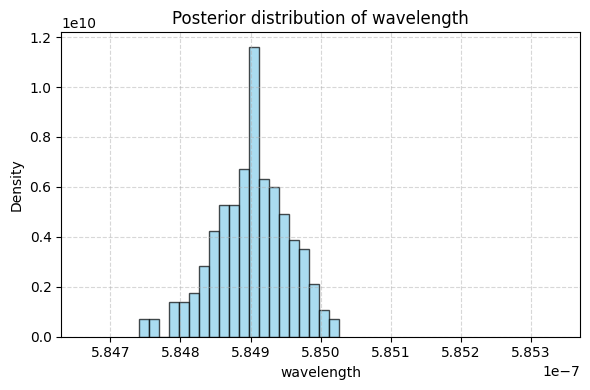

sample: 100%|██████████| 400/400 [00:02<00:00, 160.87it/s, 1 steps of size 9.52e-01. acc. prob=0.92]

CPU times: user 4.68 s, sys: 208 ms, total: 4.89 s
Wall time: 2.58 s


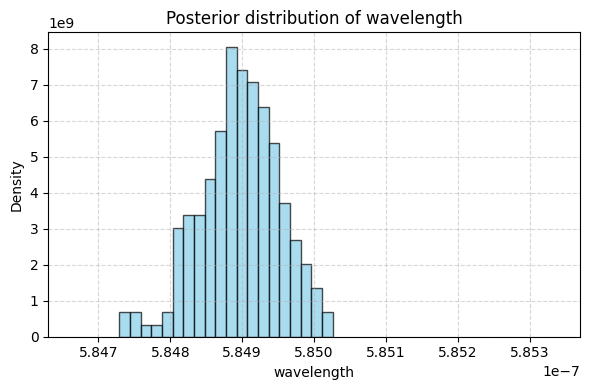

sample: 100%|██████████| 400/400 [00:02<00:00, 153.41it/s, 1 steps of size 9.46e-01. acc. prob=0.92] 


CPU times: user 4.87 s, sys: 208 ms, total: 5.08 s
Wall time: 2.72 s


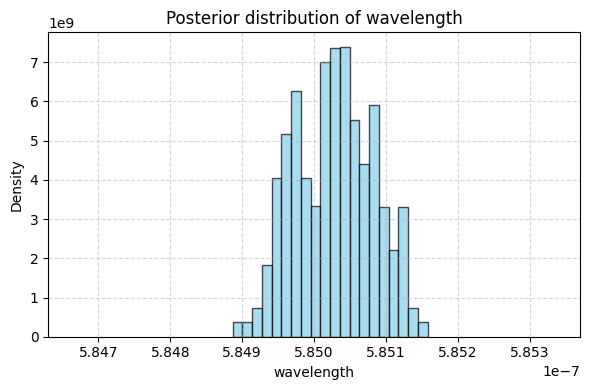

sample: 100%|██████████| 400/400 [00:02<00:00, 151.27it/s, 1 steps of size 1.01e+00. acc. prob=0.91]

CPU times: user 4.93 s, sys: 201 ms, total: 5.13 s
Wall time: 2.73 s


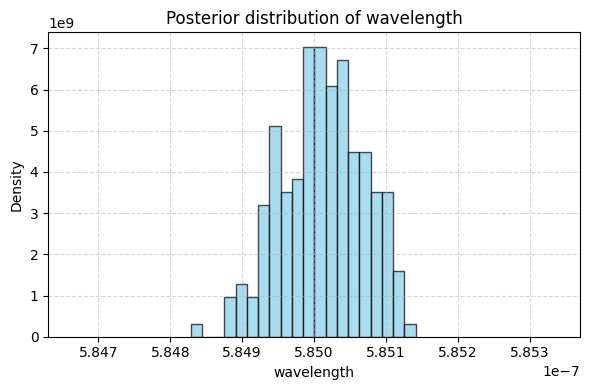

sample: 100%|██████████| 400/400 [00:02<00:00, 153.69it/s, 1 steps of size 1.16e+00. acc. prob=0.90] 


CPU times: user 4.73 s, sys: 205 ms, total: 4.94 s
Wall time: 2.71 s


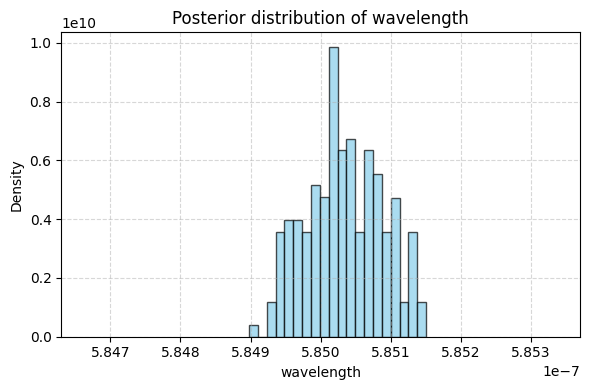

In [7]:
# normal, just circular aperture
square_errors_by_flux = []
cramer_rao_bounds = []

for flux in fluxes:
    source = dl.PointSource(np.array([wavelength]),flux = flux)
    telescope = dl.Telescope(optics, ('source', source))
    psf = telescope.model()

    flux_errors = []

    for i in np.arange(num_trials):
        key = jr.PRNGKey(i)
        data = jr.poisson(key, psf)

        %time sampler.run(jr.PRNGKey(0), data, telescope, flux)
        samples = sampler.get_samples()
        median = np.median(samples['wavelength'].flatten())

        # convert to nm here, otherwise we die later
        square_error = ((median - wavelength)*(10**9))**2
        flux_errors.append(square_error)

        # plot of distribution
        for param, values in samples.items():
            plt.figure(figsize=(6, 4))
            plt.hist(values.flatten(), bins=20, density=True, alpha=0.7, color='skyblue', edgecolor='black')
            plt.title(f"Posterior distribution of {param}")
            plt.xlabel(param)
            plt.ylabel("Density")
            plt.xlim((1-0.02*np.sqrt(1000)/np.sqrt(flux))*wavelength,(1+0.02*np.sqrt(1000)/np.sqrt(flux))*wavelength)
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

    square_errors_by_flux.append(flux_errors)
    
    crb_flux = crb(wavelength, flux, diameter, our_rmax)
    cramer_rao_bounds.append(crb_flux)

In [8]:
variances = np.array([np.mean(np.array(errors)) for errors in square_errors_by_flux])
var_of_var = np.array([np.var(np.array(errors)) for errors in square_errors_by_flux])

# variance of MSE: have to divide by number of trials: want a measure of the error about the mean
var_of_mse = var_of_var / num_trials

#stderr_of_mse = np.sqrt(var_of_mse)

# then apply 'delta method' to get variance of RMSE (which what we're plotting, equiv to cramer rao)
rmse = np.sqrt(variances)
var_of_rmse = (1 / (2 * rmse))**2 * var_of_mse

stderr_of_rmse = np.sqrt(var_of_rmse)

Model time: 1.5707 seconds.
Model time: 0.0109 seconds.
Model time: 1.3985 seconds.
Model time: 0.0106 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0214 seconds.
Model time: 0.0108 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 155.63it/s, 1 steps of size 9.62e-01. acc. prob=0.93]


CPU times: user 9.75 s, sys: 366 ms, total: 10.1 s
Wall time: 7.65 s


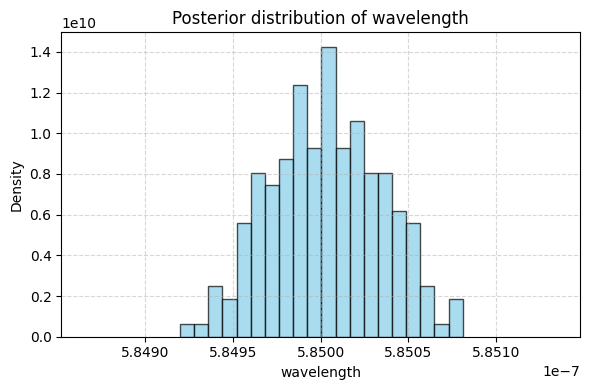

Model time: 0.0133 seconds.
Model time: 0.0224 seconds.
Model time: 0.0106 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0189 seconds.
Model time: 0.0123 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 138.28it/s, 1 steps of size 1.26e+00. acc. prob=0.93]


CPU times: user 5.17 s, sys: 276 ms, total: 5.44 s
Wall time: 2.99 s


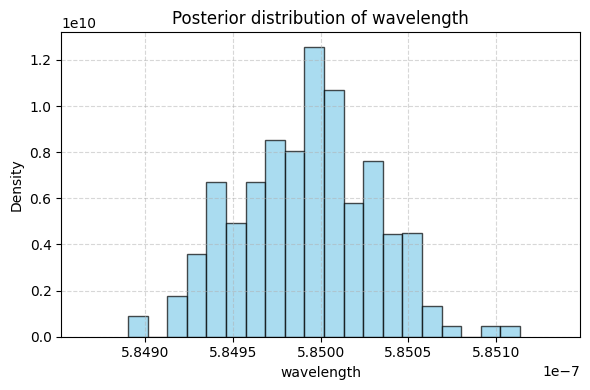

Model time: 0.0139 seconds.
Model time: 0.0197 seconds.
Model time: 0.0109 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0183 seconds.
Model time: 0.0120 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 130.25it/s, 1 steps of size 1.58e+00. acc. prob=0.92] 

CPU times: user 5.41 s, sys: 291 ms, total: 5.7 s
Wall time: 3.16 s


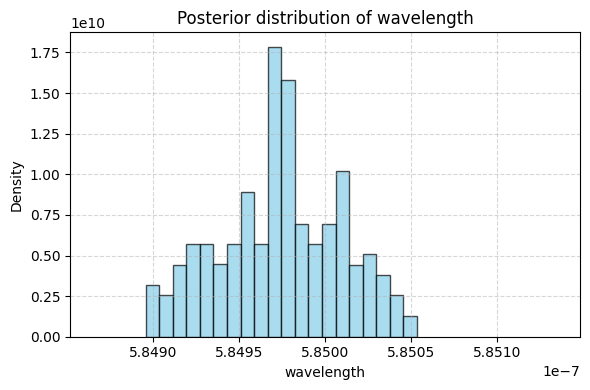

Model time: 0.0142 seconds.
Model time: 0.0204 seconds.
Model time: 0.0107 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0169 seconds.
Model time: 0.0105 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 140.21it/s, 1 steps of size 9.11e-01. acc. prob=0.93] 

CPU times: user 5.16 s, sys: 263 ms, total: 5.42 s
Wall time: 2.94 s


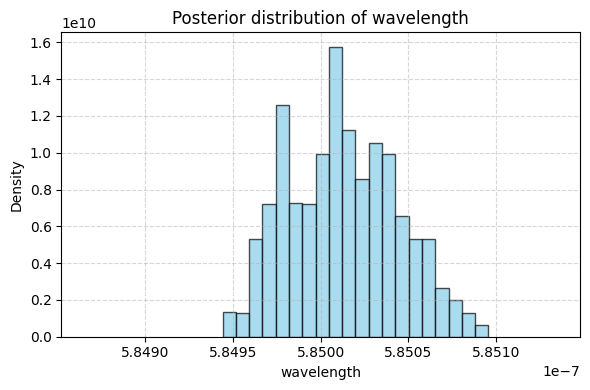

Model time: 0.0142 seconds.
Model time: 0.0218 seconds.
Model time: 0.0105 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0177 seconds.
Model time: 0.0108 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 137.68it/s, 1 steps of size 9.81e-01. acc. prob=0.93]

CPU times: user 5.1 s, sys: 277 ms, total: 5.38 s
Wall time: 3 s


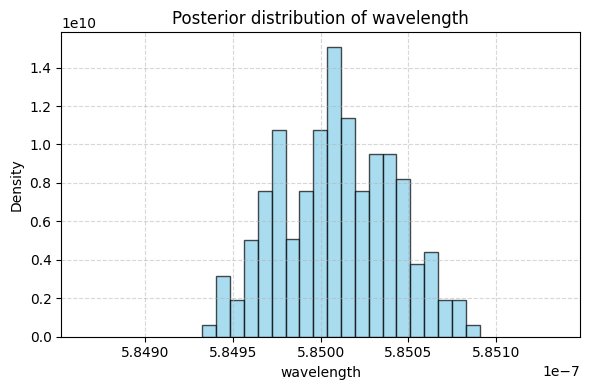

Model time: 0.0158 seconds.
Model time: 0.0222 seconds.
Model time: 0.0119 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0190 seconds.
Model time: 0.0126 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 129.53it/s, 1 steps of size 9.71e-01. acc. prob=0.94]

CPU times: user 5.46 s, sys: 302 ms, total: 5.77 s
Wall time: 3.18 s


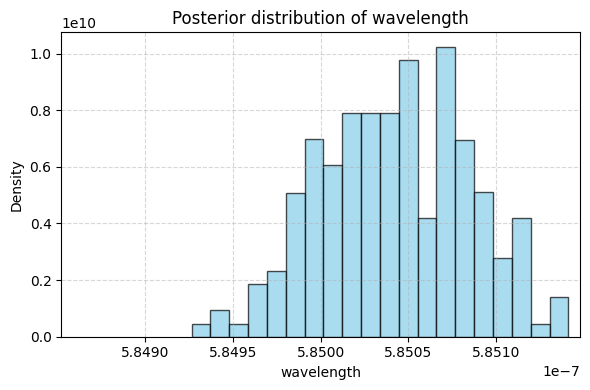

Model time: 0.0170 seconds.
Model time: 0.0215 seconds.
Model time: 0.0112 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0254 seconds.
Model time: 0.0107 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 135.98it/s, 1 steps of size 9.97e-01. acc. prob=0.92]


CPU times: user 5.35 s, sys: 260 ms, total: 5.61 s
Wall time: 3.04 s


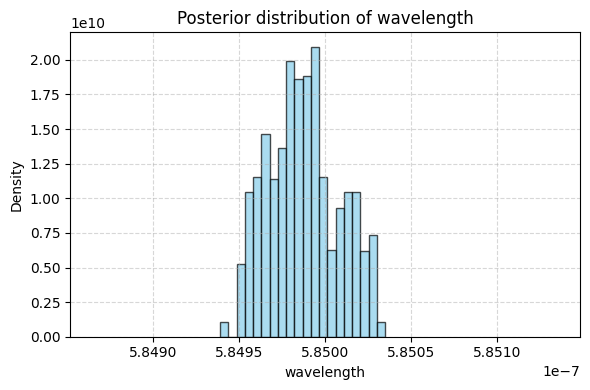

Model time: 0.0155 seconds.
Model time: 0.0204 seconds.
Model time: 0.0111 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0179 seconds.
Model time: 0.0105 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 137.61it/s, 3 steps of size 1.06e+00. acc. prob=0.92]

CPU times: user 5.38 s, sys: 269 ms, total: 5.65 s
Wall time: 3 s


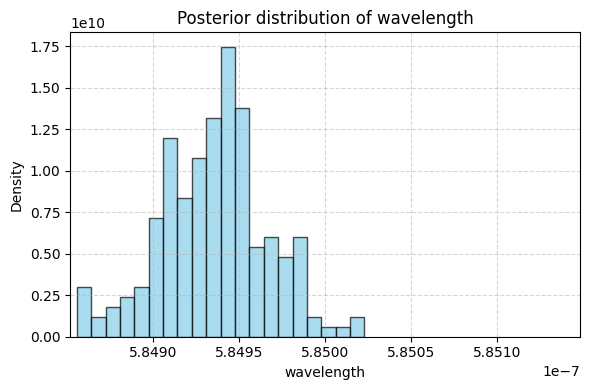

Model time: 0.0155 seconds.
Model time: 0.0214 seconds.
Model time: 0.0109 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0176 seconds.
Model time: 0.0108 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 154.82it/s, 1 steps of size 1.10e+00. acc. prob=0.91]


CPU times: user 4.62 s, sys: 250 ms, total: 4.87 s
Wall time: 2.69 s


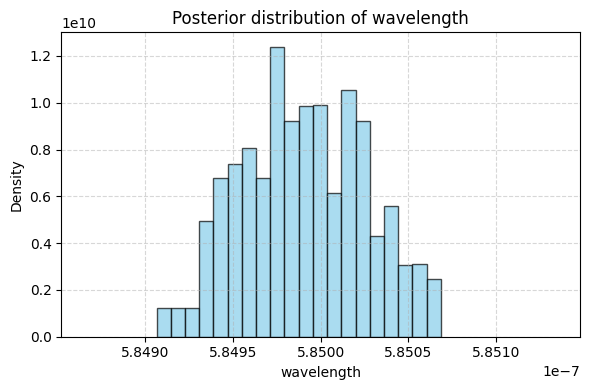

Model time: 0.0138 seconds.
Model time: 0.0212 seconds.
Model time: 0.0109 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0196 seconds.
Model time: 0.0106 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 137.04it/s, 1 steps of size 1.08e+00. acc. prob=0.92]

CPU times: user 5.29 s, sys: 258 ms, total: 5.55 s
Wall time: 3.02 s


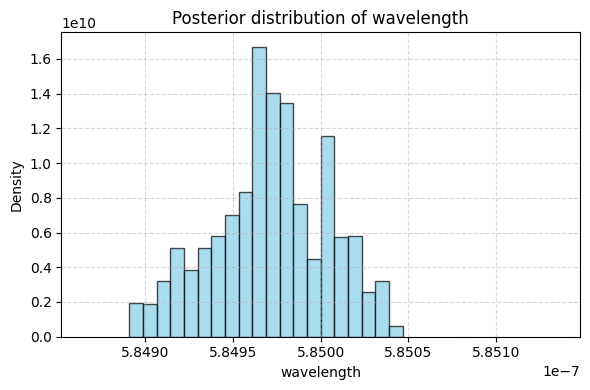

Model time: 0.0151 seconds.
Model time: 0.0119 seconds.
Model time: 0.0201 seconds.
Model time: 0.0110 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0182 seconds.
Model time: 0.0106 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 146.72it/s, 3 steps of size 1.28e+00. acc. prob=0.87]


CPU times: user 4.86 s, sys: 244 ms, total: 5.1 s
Wall time: 2.83 s


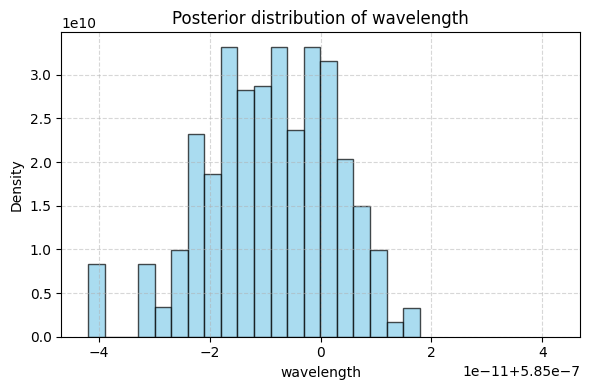

Model time: 0.0152 seconds.
Model time: 0.0214 seconds.
Model time: 0.0113 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0189 seconds.
Model time: 0.0104 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 142.18it/s, 1 steps of size 1.20e+00. acc. prob=0.93]


CPU times: user 5.16 s, sys: 249 ms, total: 5.41 s
Wall time: 2.92 s


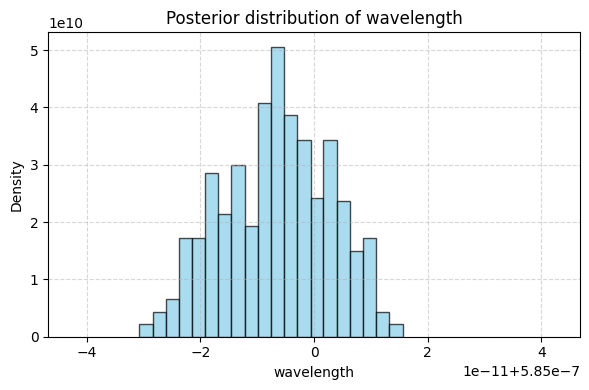

Model time: 0.0148 seconds.
Model time: 0.0223 seconds.
Model time: 0.0109 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0183 seconds.
Model time: 0.0112 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 138.01it/s, 1 steps of size 1.58e+00. acc. prob=0.89] 


CPU times: user 5.22 s, sys: 254 ms, total: 5.48 s
Wall time: 3 s


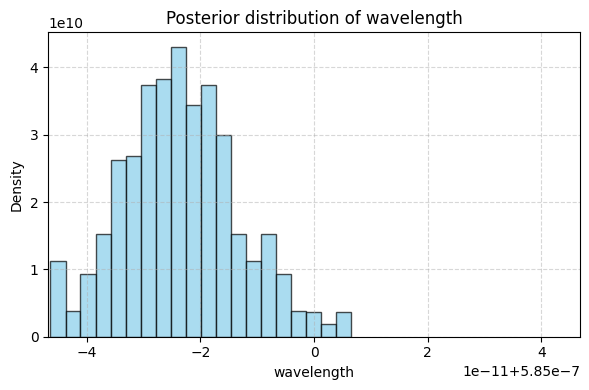

Model time: 0.0144 seconds.
Model time: 0.0216 seconds.
Model time: 0.0118 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0192 seconds.
Model time: 0.0116 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 139.71it/s, 1 steps of size 1.34e+00. acc. prob=0.90] 


CPU times: user 5.22 s, sys: 265 ms, total: 5.48 s
Wall time: 2.97 s


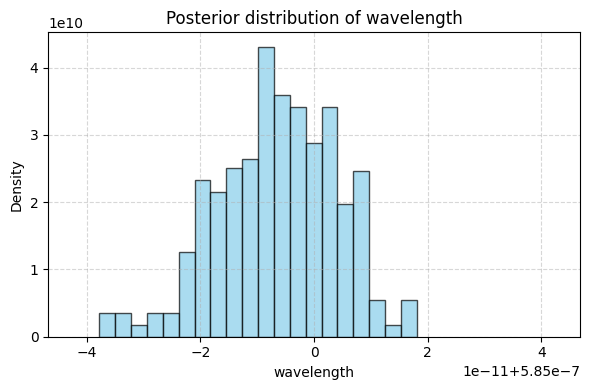

Model time: 0.0152 seconds.
Model time: 0.0212 seconds.
Model time: 0.0110 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0188 seconds.
Model time: 0.0110 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 134.43it/s, 1 steps of size 8.51e-01. acc. prob=0.93]


CPU times: user 5.32 s, sys: 248 ms, total: 5.57 s
Wall time: 3.08 s


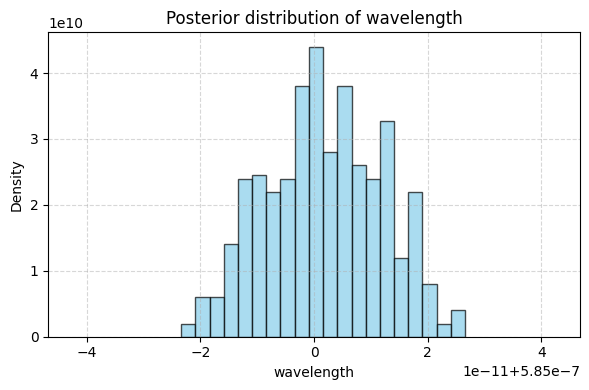

Model time: 0.0156 seconds.
Model time: 0.0205 seconds.
Model time: 0.0112 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0186 seconds.
Model time: 0.0108 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 134.63it/s, 1 steps of size 9.44e-01. acc. prob=0.93] 

CPU times: user 5.18 s, sys: 294 ms, total: 5.47 s
Wall time: 3.07 s


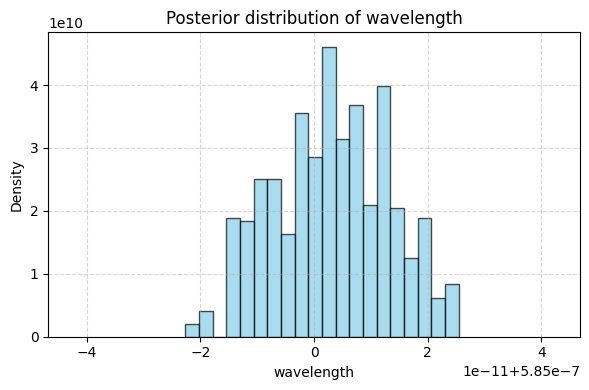

Model time: 0.0164 seconds.
Model time: 0.0237 seconds.
Model time: 0.0112 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0188 seconds.
Model time: 0.0112 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 148.41it/s, 1 steps of size 1.04e+00. acc. prob=0.93]


CPU times: user 4.77 s, sys: 279 ms, total: 5.05 s
Wall time: 2.81 s


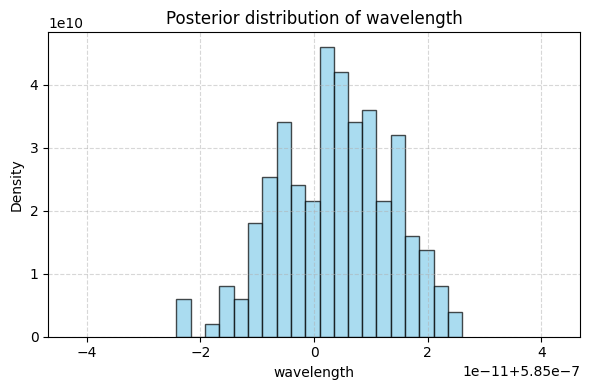

Model time: 0.0128 seconds.
Model time: 0.0213 seconds.
Model time: 0.0117 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0179 seconds.
Model time: 0.0109 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 138.54it/s, 3 steps of size 1.35e+00. acc. prob=0.89] 


CPU times: user 5.02 s, sys: 280 ms, total: 5.3 s
Wall time: 3 s


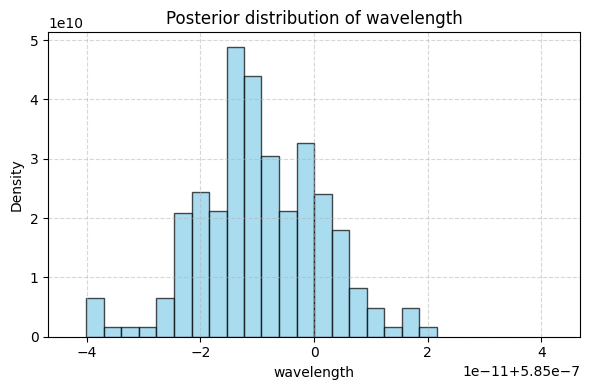

Model time: 0.0155 seconds.
Model time: 0.0227 seconds.
Model time: 0.0120 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0198 seconds.
Model time: 0.0123 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 122.94it/s, 1 steps of size 8.58e-01. acc. prob=0.94]


CPU times: user 5.65 s, sys: 319 ms, total: 5.96 s
Wall time: 3.36 s


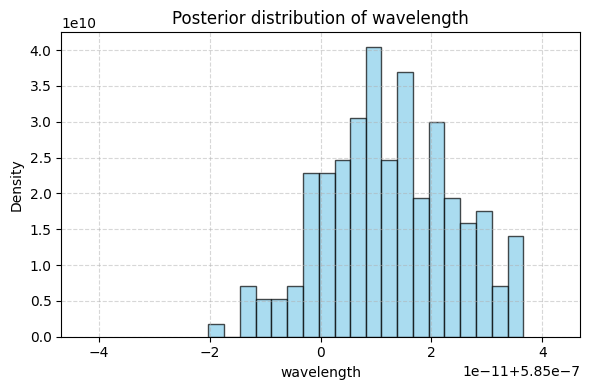

Model time: 0.0159 seconds.
Model time: 0.0209 seconds.
Model time: 0.0120 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0184 seconds.
Model time: 0.0110 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 120.82it/s, 1 steps of size 7.80e-01. acc. prob=0.94] 

CPU times: user 5.9 s, sys: 330 ms, total: 6.23 s
Wall time: 3.42 s


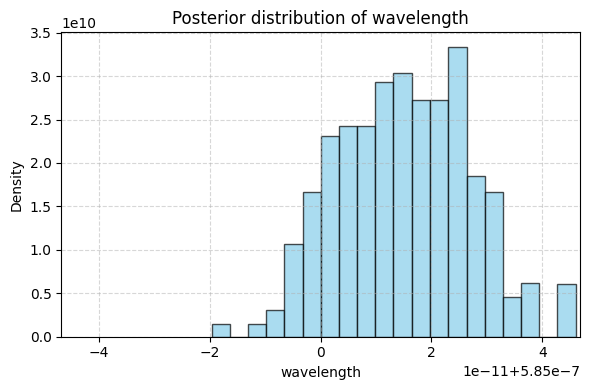

Model time: 0.0141 seconds.
Model time: 0.0120 seconds.
Model time: 0.0223 seconds.
Model time: 0.0122 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0806 seconds.
Model time: 0.0119 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 126.34it/s, 3 steps of size 8.11e-01. acc. prob=0.94]


CPU times: user 5.45 s, sys: 319 ms, total: 5.77 s
Wall time: 3.27 s


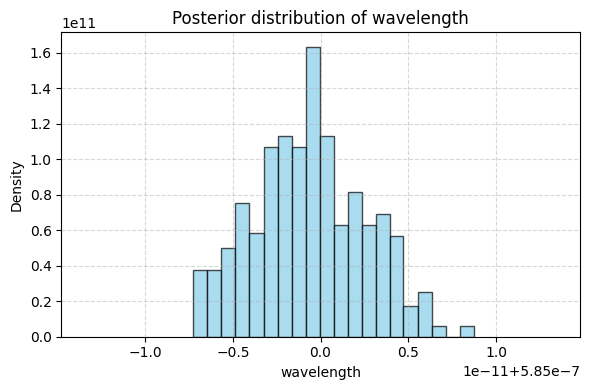

Model time: 0.0154 seconds.
Model time: 0.0306 seconds.
Model time: 0.0132 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0198 seconds.
Model time: 0.0109 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 131.12it/s, 3 steps of size 1.11e+00. acc. prob=0.92]


CPU times: user 5.42 s, sys: 308 ms, total: 5.72 s
Wall time: 3.22 s


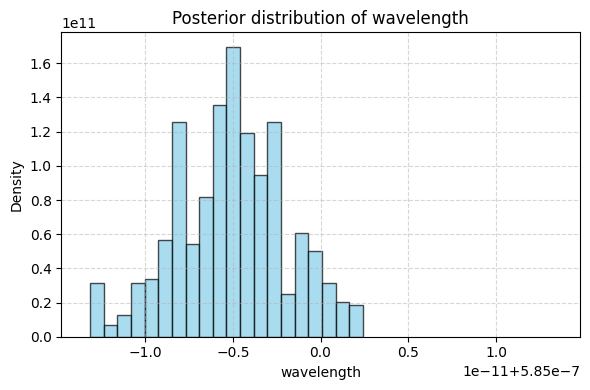

Model time: 0.0151 seconds.
Model time: 0.0212 seconds.
Model time: 0.0113 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0189 seconds.
Model time: 0.0108 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 135.52it/s, 3 steps of size 9.69e-01. acc. prob=0.92] 

CPU times: user 5.2 s, sys: 268 ms, total: 5.46 s
Wall time: 3.06 s


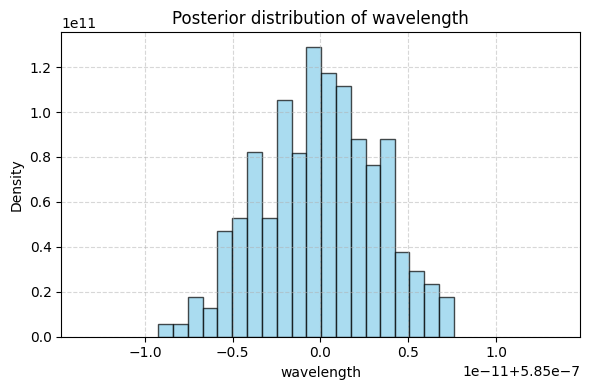

Model time: 0.0212 seconds.
Model time: 0.0213 seconds.
Model time: 0.0137 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0179 seconds.
Model time: 0.0108 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 133.09it/s, 1 steps of size 1.01e+00. acc. prob=0.93]

CPU times: user 5.29 s, sys: 287 ms, total: 5.58 s
Wall time: 3.13 s


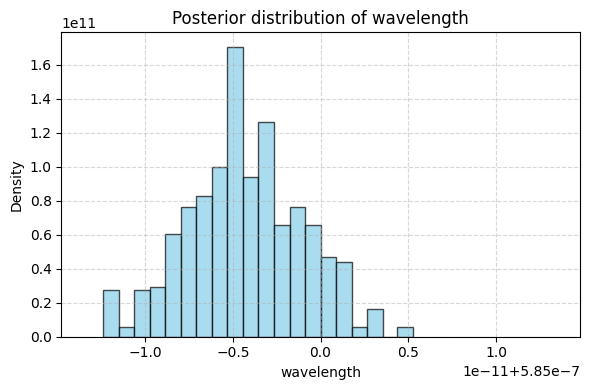

Model time: 0.0156 seconds.
Model time: 0.0222 seconds.
Model time: 0.0113 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0178 seconds.
Model time: 0.0107 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 146.95it/s, 3 steps of size 1.24e+00. acc. prob=0.91]

CPU times: user 4.91 s, sys: 269 ms, total: 5.18 s
Wall time: 2.83 s


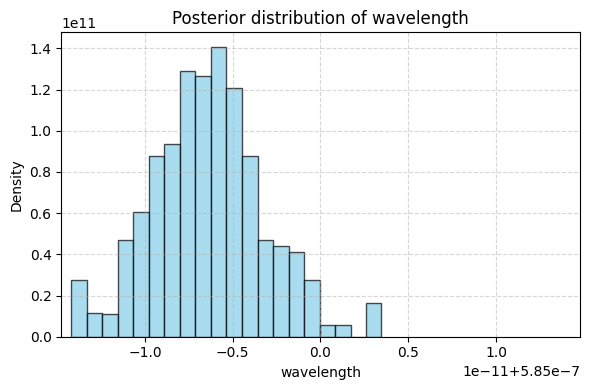

Model time: 0.0721 seconds.
Model time: 0.1071 seconds.
Model time: 0.0125 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0180 seconds.
Model time: 0.0110 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 127.20it/s, 1 steps of size 9.04e-01. acc. prob=0.94]


CPU times: user 5.74 s, sys: 311 ms, total: 6.05 s
Wall time: 3.41 s


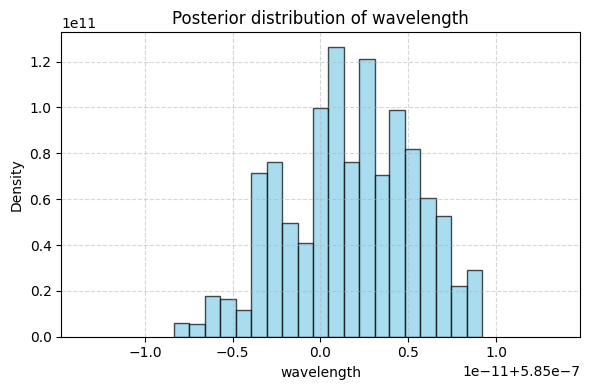

Model time: 0.0149 seconds.
Model time: 0.0217 seconds.
Model time: 0.0115 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0195 seconds.
Model time: 0.0107 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 115.14it/s, 3 steps of size 5.59e-01. acc. prob=0.94]


CPU times: user 6.17 s, sys: 331 ms, total: 6.5 s
Wall time: 3.58 s


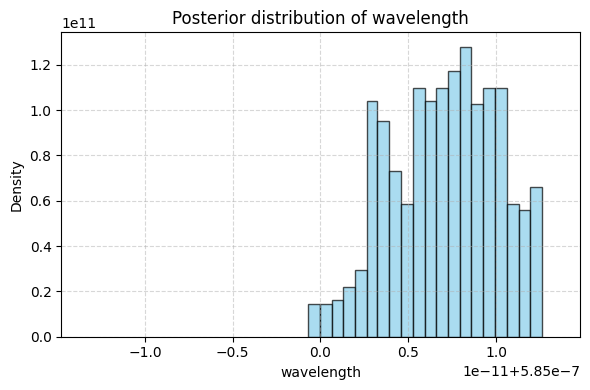

Model time: 0.0184 seconds.
Model time: 0.0240 seconds.
Model time: 0.0117 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0196 seconds.
Model time: 0.0106 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 133.03it/s, 1 steps of size 1.39e+00. acc. prob=0.90]

CPU times: user 5.36 s, sys: 277 ms, total: 5.63 s
Wall time: 3.12 s


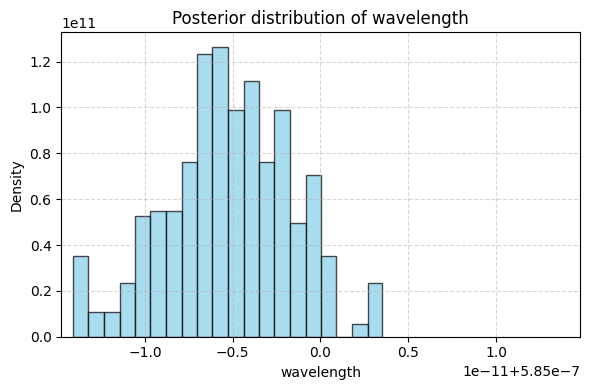

Model time: 0.0192 seconds.
Model time: 0.0236 seconds.
Model time: 0.0132 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0189 seconds.
Model time: 0.0121 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 133.39it/s, 1 steps of size 8.41e-01. acc. prob=0.91] 

CPU times: user 5.24 s, sys: 274 ms, total: 5.51 s
Wall time: 3.12 s


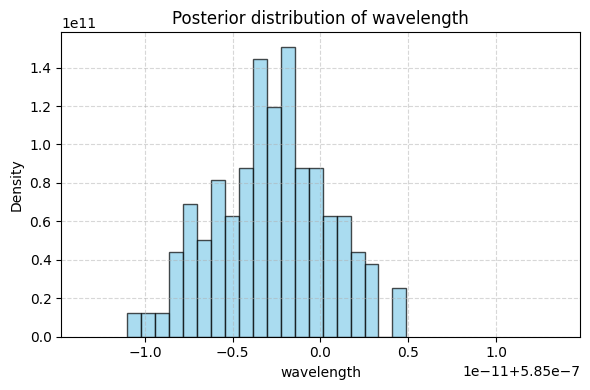

Model time: 0.0170 seconds.
Model time: 0.0216 seconds.
Model time: 0.0117 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0180 seconds.
Model time: 0.0106 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 129.42it/s, 1 steps of size 6.79e-01. acc. prob=0.93]


CPU times: user 5.44 s, sys: 289 ms, total: 5.72 s
Wall time: 3.2 s


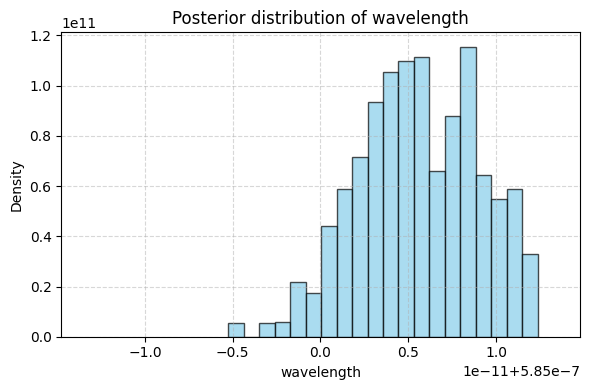

Model time: 0.0143 seconds.
Model time: 0.0133 seconds.
Model time: 0.0212 seconds.
Model time: 0.0114 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0190 seconds.
Model time: 0.0109 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 132.50it/s, 3 steps of size 8.50e-01. acc. prob=0.92]


CPU times: user 5.26 s, sys: 288 ms, total: 5.55 s
Wall time: 3.13 s


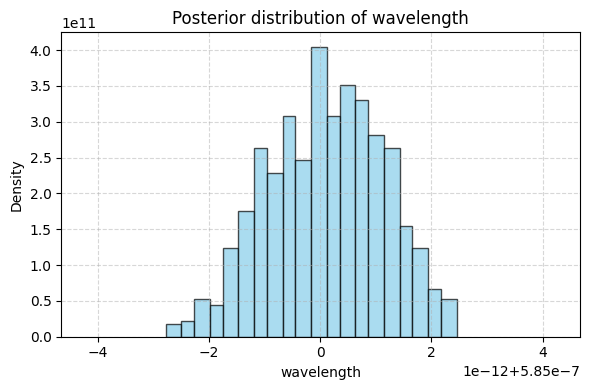

Model time: 0.0135 seconds.
Model time: 0.0205 seconds.
Model time: 0.0119 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0279 seconds.
Model time: 0.0107 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 134.13it/s, 3 steps of size 8.33e-01. acc. prob=0.92] 


CPU times: user 5.27 s, sys: 266 ms, total: 5.54 s
Wall time: 3.1 s


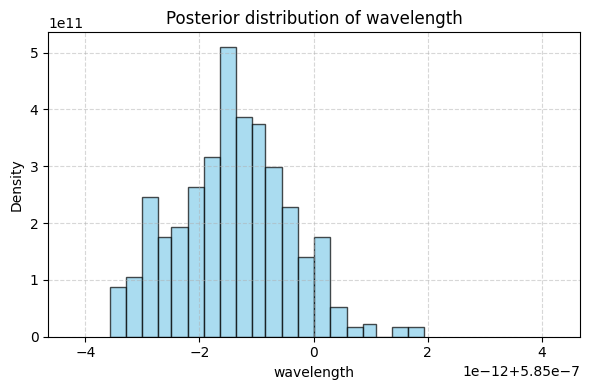

Model time: 0.0158 seconds.
Model time: 0.0212 seconds.
Model time: 0.0118 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0191 seconds.
Model time: 0.0109 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 134.66it/s, 1 steps of size 9.37e-01. acc. prob=0.94]

CPU times: user 5.34 s, sys: 294 ms, total: 5.63 s
Wall time: 3.08 s


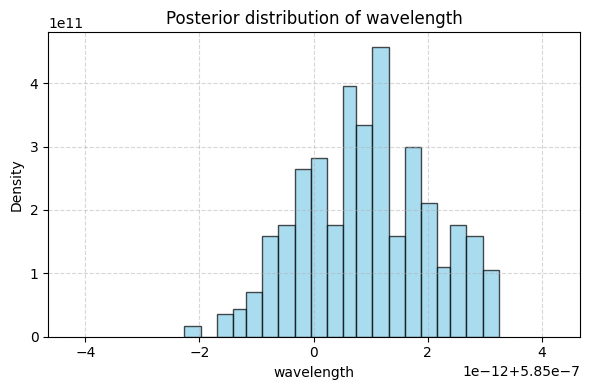

Model time: 0.0173 seconds.
Model time: 0.0213 seconds.
Model time: 0.0118 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0181 seconds.
Model time: 0.0110 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 132.43it/s, 1 steps of size 9.00e-01. acc. prob=0.92] 


CPU times: user 5.26 s, sys: 284 ms, total: 5.54 s
Wall time: 3.13 s


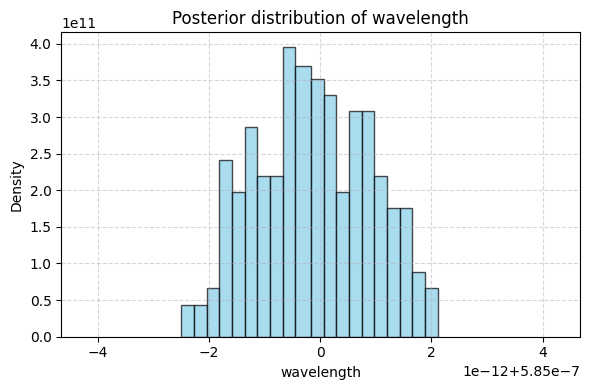

Model time: 0.0164 seconds.
Model time: 0.0209 seconds.
Model time: 0.0118 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0183 seconds.
Model time: 0.0107 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 126.95it/s, 1 steps of size 7.87e-01. acc. prob=0.94] 


CPU times: user 5.47 s, sys: 301 ms, total: 5.78 s
Wall time: 3.26 s


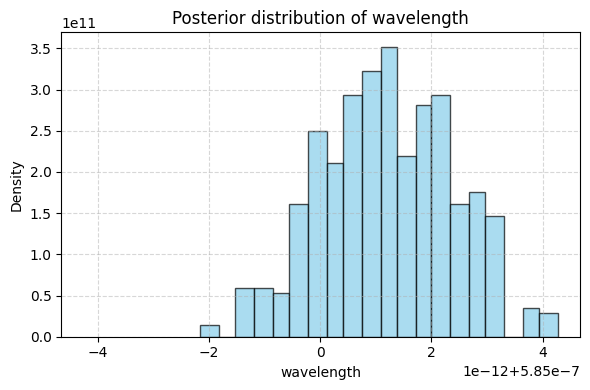

Model time: 0.0186 seconds.
Model time: 0.0204 seconds.
Model time: 0.0115 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0181 seconds.
Model time: 0.0110 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 126.82it/s, 1 steps of size 1.19e+00. acc. prob=0.93]

CPU times: user 5.49 s, sys: 299 ms, total: 5.79 s
Wall time: 3.27 s


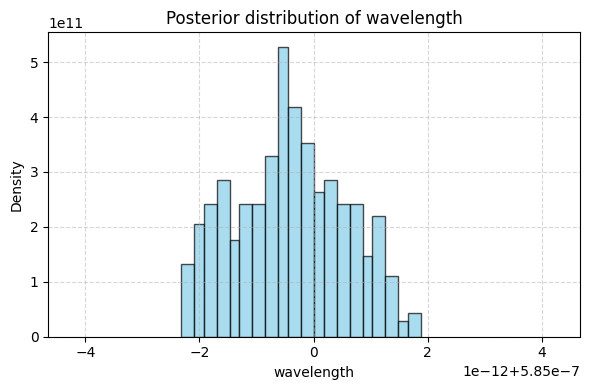

Model time: 0.0165 seconds.
Model time: 0.0215 seconds.
Model time: 0.0117 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0178 seconds.
Model time: 0.0107 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 135.60it/s, 1 steps of size 9.81e-01. acc. prob=0.93] 


CPU times: user 5.32 s, sys: 259 ms, total: 5.58 s
Wall time: 3.06 s


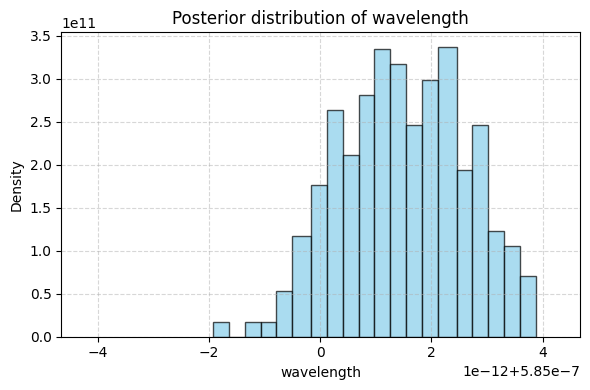

Model time: 0.0152 seconds.
Model time: 0.0224 seconds.
Model time: 0.0118 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.1219 seconds.
Model time: 0.0121 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 134.80it/s, 1 steps of size 9.96e-01. acc. prob=0.93]


CPU times: user 5.32 s, sys: 259 ms, total: 5.58 s
Wall time: 3.08 s


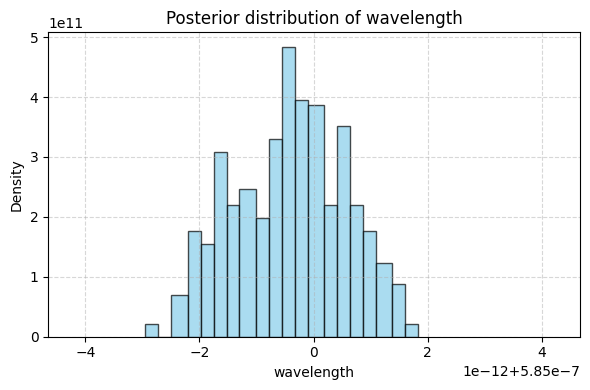

Model time: 0.0691 seconds.
Model time: 0.0202 seconds.
Model time: 0.0121 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0186 seconds.
Model time: 0.0117 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 132.06it/s, 1 steps of size 1.31e+00. acc. prob=0.94] 

CPU times: user 5.6 s, sys: 277 ms, total: 5.88 s
Wall time: 3.21 s


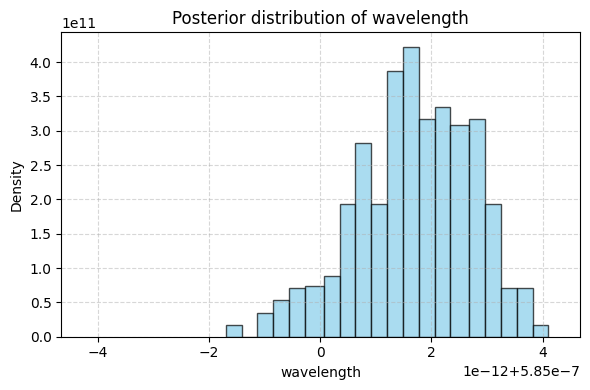

Model time: 0.0170 seconds.
Model time: 0.0213 seconds.
Model time: 0.0125 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0730 seconds.
Model time: 0.0109 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 135.37it/s, 1 steps of size 8.54e-01. acc. prob=0.93]


CPU times: user 5.22 s, sys: 282 ms, total: 5.5 s
Wall time: 3.07 s


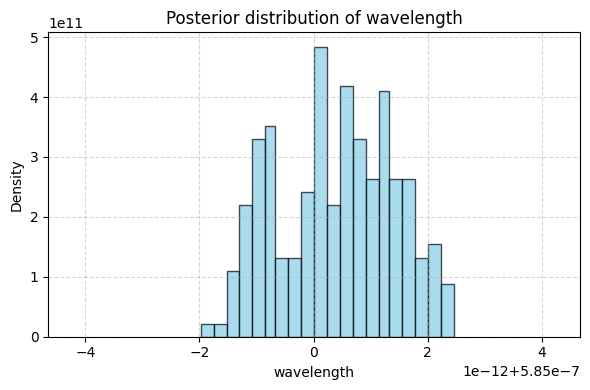

Model time: 0.0159 seconds.
Model time: 0.0152 seconds.
Model time: 0.0228 seconds.
Model time: 0.0131 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0851 seconds.
Model time: 0.0108 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 144.42it/s, 1 steps of size 8.68e-01. acc. prob=0.93]

CPU times: user 4.99 s, sys: 252 ms, total: 5.24 s
Wall time: 2.89 s


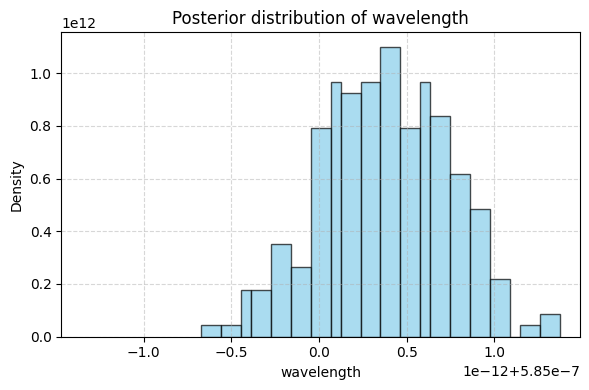

Model time: 0.0171 seconds.
Model time: 0.0203 seconds.
Model time: 0.0119 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0178 seconds.
Model time: 0.0107 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 137.42it/s, 7 steps of size 8.22e-01. acc. prob=0.92]

CPU times: user 5.24 s, sys: 251 ms, total: 5.49 s
Wall time: 3.02 s


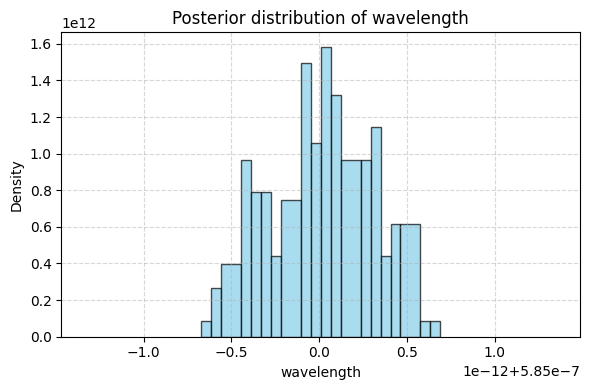

Model time: 0.0163 seconds.
Model time: 0.0219 seconds.
Model time: 0.0121 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0186 seconds.
Model time: 0.0108 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 136.52it/s, 1 steps of size 8.31e-01. acc. prob=0.92]


CPU times: user 5.26 s, sys: 242 ms, total: 5.51 s
Wall time: 3.04 s


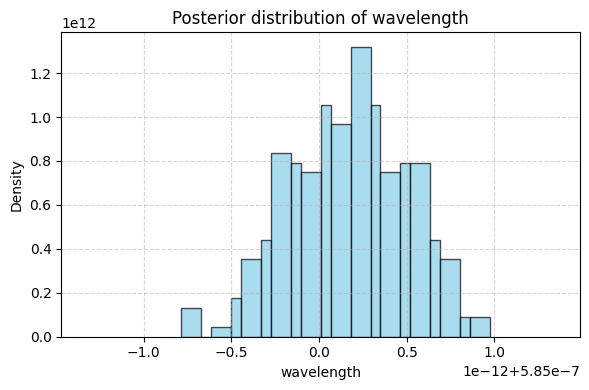

Model time: 0.0148 seconds.
Model time: 0.0202 seconds.
Model time: 0.0118 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0180 seconds.
Model time: 0.0114 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 134.87it/s, 1 steps of size 8.90e-01. acc. prob=0.91] 

CPU times: user 5.34 s, sys: 244 ms, total: 5.58 s
Wall time: 3.08 s


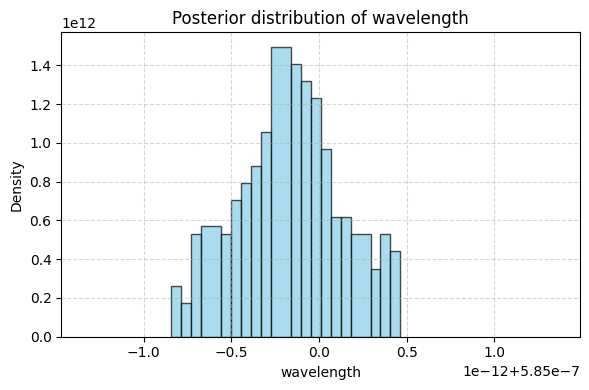

Model time: 0.0162 seconds.
Model time: 0.0210 seconds.
Model time: 0.0119 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0178 seconds.
Model time: 0.0109 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 130.42it/s, 1 steps of size 1.26e+00. acc. prob=0.91] 


CPU times: user 5.3 s, sys: 278 ms, total: 5.57 s
Wall time: 3.18 s


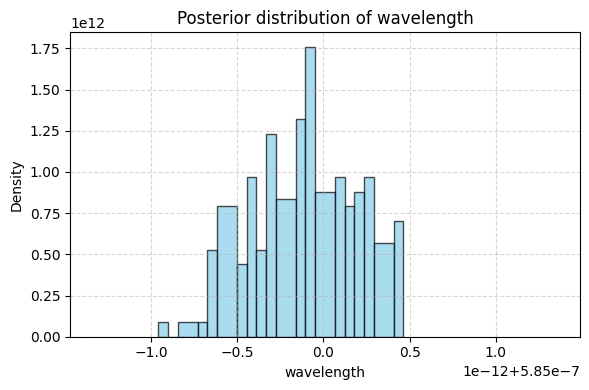

Model time: 0.0171 seconds.
Model time: 0.0228 seconds.
Model time: 0.0136 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0195 seconds.
Model time: 0.0128 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 120.48it/s, 1 steps of size 7.69e-01. acc. prob=0.93]


CPU times: user 5.81 s, sys: 325 ms, total: 6.13 s
Wall time: 3.45 s


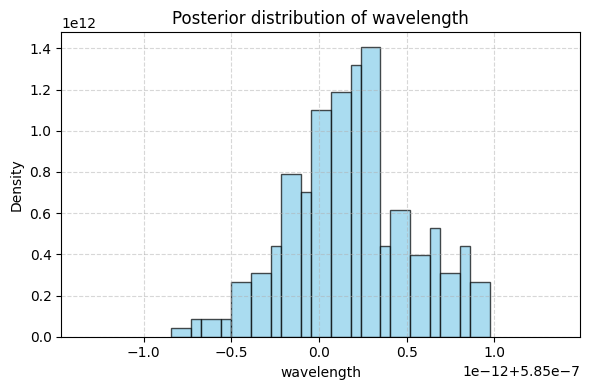

Model time: 0.0168 seconds.
Model time: 0.0229 seconds.
Model time: 0.0127 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0186 seconds.
Model time: 0.0118 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 112.14it/s, 3 steps of size 6.13e-01. acc. prob=0.92] 


CPU times: user 6.21 s, sys: 361 ms, total: 6.57 s
Wall time: 3.68 s


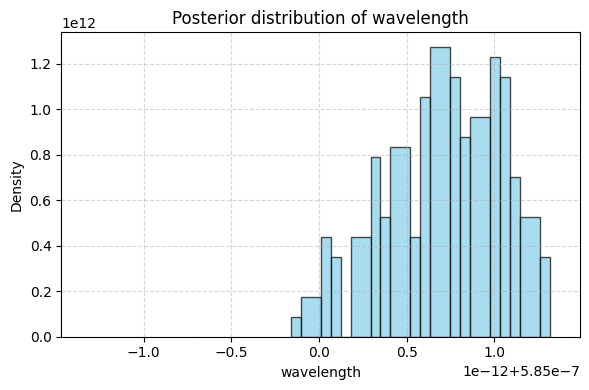

Model time: 0.0191 seconds.
Model time: 0.0231 seconds.
Model time: 0.0138 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0184 seconds.
Model time: 0.0135 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 136.50it/s, 1 steps of size 1.50e+00. acc. prob=0.89]

CPU times: user 5.19 s, sys: 279 ms, total: 5.47 s
Wall time: 3.12 s


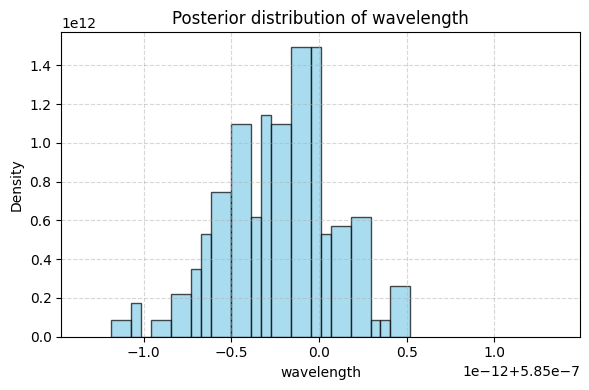

Model time: 0.0177 seconds.
Model time: 0.0224 seconds.
Model time: 0.0135 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0189 seconds.
Model time: 0.0132 seconds.


sample: 100%|██████████| 400/400 [00:02<00:00, 143.96it/s, 1 steps of size 9.79e-01. acc. prob=0.92]

CPU times: user 5.01 s, sys: 261 ms, total: 5.27 s
Wall time: 2.9 s


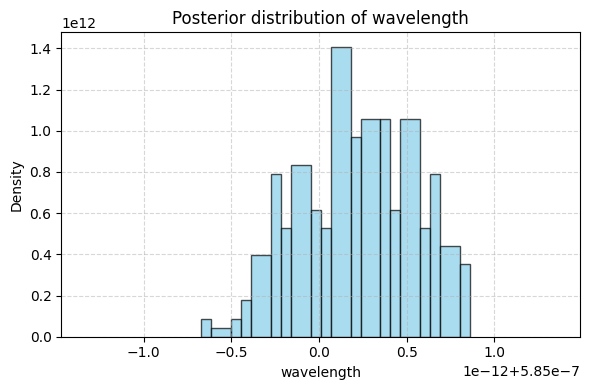

Model time: 0.0401 seconds.
Model time: 0.0213 seconds.
Model time: 0.0125 seconds.


  0%|          | 0/400 [00:00<?, ?it/s]

Model time: 0.0179 seconds.
Model time: 0.0109 seconds.


sample: 100%|██████████| 400/400 [00:03<00:00, 127.15it/s, 1 steps of size 8.60e-01. acc. prob=0.92]


CPU times: user 5.46 s, sys: 288 ms, total: 5.75 s
Wall time: 3.28 s


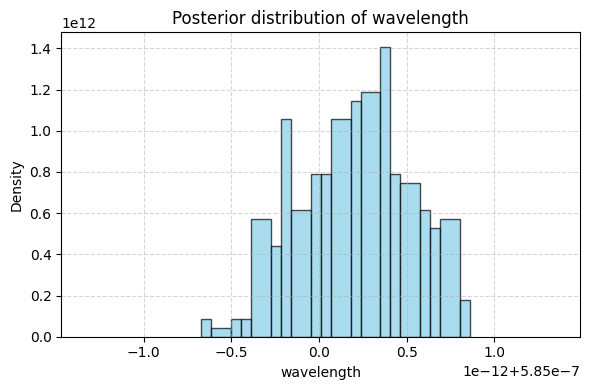

In [3]:
# toliman aperture, include period, difference. Correct for flux as well
period = 304e-6 
difference = np.pi * 0.348
center_wl = wavelength # (if we do multiple wavelengths can also change this)

square_errors_by_flux_toliman = []
cramer_rao_bounds_toliman = []

for flux in fluxes:
    flux_toliman = 1/(jv(1, difference/4)**2 * jv(0, difference/4)**2)*flux
    source = dl.PointSource(np.array([wavelength]),flux = flux_toliman)
    telescope = dl.Telescope(optics, ('source', source))
    sidelobescope = dlT.SideLobeTelescope(telescope, period, difference)
    psf = sidelobescope.model_sidelobes(center_wavelength = center_wl) # don't want to downsample

    flux_errors = []

    for i in np.arange(num_trials):
        key = jr.PRNGKey(i)
        data = jr.poisson(key, psf)

        %time sampler.run(jr.PRNGKey(0), data, sidelobescope, flux, True, center_wl)
        samples = sampler.get_samples()
        median = np.median(samples['wavelength'].flatten())

        # convert to nm here, otherwise we die later
        square_error = ((median - wavelength)*(10**9))**2
        flux_errors.append(square_error)

        # plot of distribution
        for param, values in samples.items():
            plt.figure(figsize=(6, 4))
            plt.hist(values.flatten(), bins=20, density=True, alpha=0.7, color='skyblue', edgecolor='black')
            plt.title(f"Posterior distribution of {param}")
            plt.xlabel(param)
            plt.ylabel("Density")
            plt.xlim((1-0.00008*np.sqrt(1000)/np.sqrt(flux))*wavelength,(1+0.00008*np.sqrt(1000)/np.sqrt(flux))*wavelength)
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

    square_errors_by_flux_toliman.append(flux_errors)
    
    crb_flux = crb_toliman(wavelength, flux, diameter, period)
    cramer_rao_bounds_toliman.append(crb_flux)

In [4]:
variances_toliman = np.array([np.mean(np.array(errors)) for errors in square_errors_by_flux_toliman])
var_of_var_toliman = np.array([np.var(np.array(errors)) for errors in square_errors_by_flux_toliman])

# variance of MSE: have to divide by number of trials: want a measure of the error about the mean
var_of_mse_toliman = var_of_var_toliman / num_trials

#stderr_of_mse = np.sqrt(var_of_mse)

# then apply 'delta method' to get variance of RMSE (which what we're plotting, equiv to cramer rao)
rmse_toliman = np.sqrt(variances_toliman)
var_of_rmse_toliman = (1 / (2 * rmse_toliman))**2 * var_of_mse_toliman

stderr_of_rmse_toliman = np.sqrt(var_of_rmse_toliman)

In [ ]:
# good plotting style
plt.style.use('sty.mplstyle')

In [ ]:
fluxes_longer = np.logspace(1,7,7)
crbs_longer = crb(wavelength, fluxes_longer, diameter, our_rmax)
crbs_toliman_longer = crb_toliman(wavelength, fluxes_longer, diameter, period)

In [109]:
import matplotlib.patheffects as pe
text_path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]
path_effects = [pe.Stroke(linewidth=6, foreground='k'), pe.Normal()]

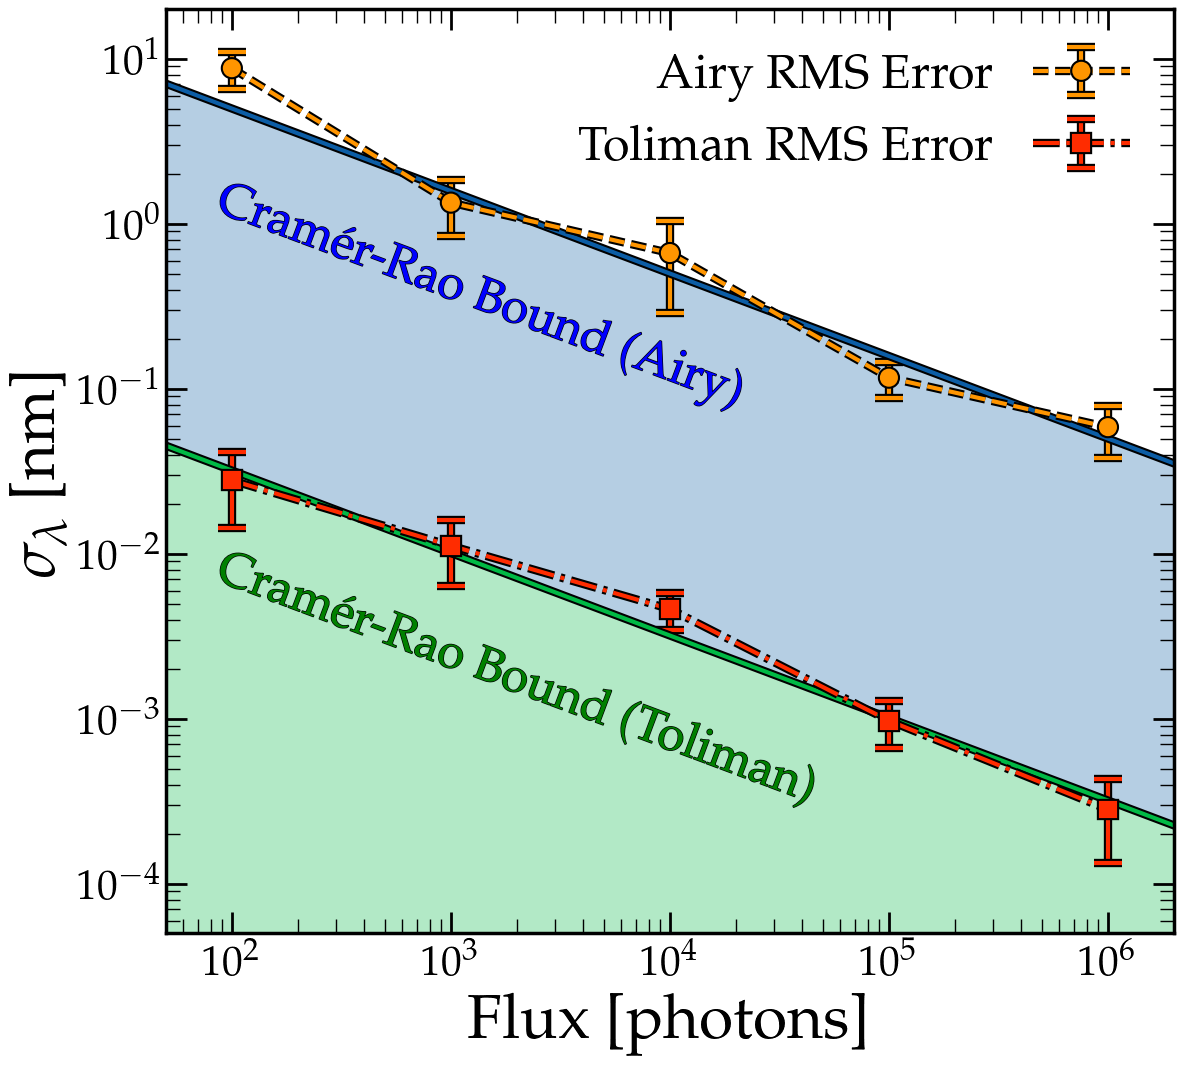

In [ ]:
plt.figure(figsize=(13,12))
plt.fill_between(fluxes_longer, crbs_longer, crbs_toliman_longer, alpha=0.3)
plt.fill_between(fluxes_longer, crbs_toliman_longer, 1e-5, alpha=0.3)

plt.errorbar(fluxes_longer, crbs_longer,path_effects=path_effects)
plt.errorbar(fluxes_longer, crbs_toliman_longer, path_effects=path_effects)

plt.text(10**(1.9),10**(-1.1),'Cramér-Rao Bound (Airy)',path_effects=text_path_effects,color='blue',fontsize=35,rotation=-20.5)
plt.text(10**(1.9),10**(-3.5),'Cramér-Rao Bound (Toliman)',path_effects=text_path_effects,color='green',fontsize=35, rotation=-20.5)

plt.errorbar(fluxes, rmse, yerr=stderr_of_rmse*2, capsize=10, marker='o', ms=10, mew=3, linestyle='--', 
             path_effects=path_effects,
             label='Airy RMS Error')
plt.errorbar(fluxes, rmse_toliman, yerr=stderr_of_rmse_toliman*2, capsize=10, marker='s', ms=10, mew=3, linestyle='-.', 
             path_effects=path_effects,
             label='Toliman RMS Error')

plt.xscale('log')
plt.yscale('log')
plt.xlim(10**(1.7),10**(6.3))
plt.ylim(10**(-4.3),10**(1.3))
plt.xlabel('Flux [photons]')
plt.ylabel(r'$\sigma_\lambda$ [nm]')
plt.legend(markerfirst=False)
#plt.savefig('cramer_rao_plot.pdf',transparent=False,bbox_inches='tight')
#plt.savefig('cramer_rao_plot.png',dpi=300,transparent=False,bbox_inches='tight')
plt.show()
# Nice plot